In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#import surprise
#import surprise.model_selection 
#from surprise import SVD

import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

# Загрузка и обработка данных

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Отсортируем данные по возрастанию ts

In [12]:
#dataframe = pd.read_csv('ratings.csv')
dataframe = pd.read_csv('/content/drive/MyDrive/AI Masters/ratings.csv')
dataframe.sort_values('ts', inplace = True)
dataframe.reset_index(drop=True, inplace = True)
dataframe.rename(columns = {'user_uid':'user_id', 'element_uid':'item_id'}, inplace = True)

Воспользуемся LabelEncoder для юзеров и айтемов

In [13]:
u_enc = LabelEncoder()
i_enc = LabelEncoder()
dataframe['user_id'] = u_enc.fit_transform(dataframe['user_id'])
dataframe['item_id'] = i_enc.fit_transform(dataframe['item_id'])

In [14]:
dataframe.head()

,user_id,item_id,rating,ts
0,65882,6586,2,4.173065e+07
1,86840,5912,7,4.173078e+07
2,62263,2443,8,4.173079e+07
3,5710,4521,8,4.173085e+07
4,30028,1110,8,4.173086e+07


Разобьём данные на обучающую и тестовую выборки

In [15]:
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(columns = ['rating','ts']), dataframe.rating, test_size=0.2, random_state=42, shuffle = False)

Напишем класс для хранения данных

In [16]:
class RatingsDataset(Dataset):
    
    def __init__(self, X, y=None):

        self.users = X.user_id
        self.items = X.item_id
        self.ratings = y
        
    def __len__(self,):

        return len(self.users)

    def __getitem__(self, i):
        
        return self.users[i], self.items[i], self.ratings[i]
    
    @staticmethod
    def collate(batch):
        
        users = torch.tensor([elem[0] for elem in batch])
        items = torch.tensor([elem[1] for elem in batch])
        ratings = torch.tensor([elem[2] for elem in batch])    
        
        return users, items, ratings

Обработка данных для surprise SVD

In [ ]:
reader = surprise.Reader(rating_scale=(0, 10)) # Зададим разброс оценок
data = surprise.Dataset.load_from_df(dataframe[['user_id', 'item_id', 'rating']], reader)

In [ ]:
train_data_surprise, test_data_surprise = surprise.model_selection.train_test_split(data, test_size=0.2, random_state=42, shuffle = False)

# Реализация моделей

## 1. SVD(Funk MF + bias)

Метод SVD был честно реализован мной в дз1. Сейчас воспользуемся готовой реализацией из библиотеки surprise, так как хочется протестировать модели на одном большом датасете REKKO, а моя реализация не позволяет этого сделать, так как затрачивает слишком много памяти. Скорее всего, в реализации surprise используются sparse matrixes, так как в матрице рейтингов R действительно известно мало значений. 

С помощью CV оценим оценим качество модели SVD для 8, 10 и 12 факторов в разложении матрицы рейтингов

In [ ]:
for k in [8, 10, 12]:
    algo = SVD(n_factors = k,random_state = 42, verbose = False) #отключим вывод логирования
    cv = surprise.model_selection.cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    print(str(k)+'-factors SVD:',np.mean(cv['test_rmse']))

8-factors SVD: 1.8485271015417968
10-factors SVD: 1.8501988296353138
12-factors SVD: 1.8518200539191731


Видим, что наилучшее качество получилось у модели с 8 факторами

## 2. NeuMF

https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401

In [17]:
class Block(nn.Module):
    def __init__(self, input_size, output_size, activation = True, dropout = 0.5):
        super().__init__()
        
        self.linear = nn.Linear(input_size, output_size)
        if activation:
            self.activation = nn.ReLU()
        else:
            nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        y1 = self.linear(x)
        y2 = self.activation(y1)
        y3 = self.dropout(y2)
        return y3

In [18]:
class MF(nn.Module):
    def __init__(self, n_users, n_items, n_factors, activation, dropout):
        super().__init__()
        
        self.n_factors = n_factors
        self.n_users = n_users
        self.n_items = n_items
        self.p = dropout
   
        self.u_emb = nn.Embedding(self.n_users, self.n_factors)
        self.i_emb = nn.Embedding(self.n_items, self.n_factors)
        
        self.dropout = torch.nn.Dropout(self.p)
        self.out_linear = torch.nn.Linear(in_features = self.n_factors, out_features = 1)

    def forward(self, users, items): 
        
        features = torch.mul(self.u_emb(users), self.i_emb(items))
        
        out = self.dropout(features)
        
        return self.out_linear(out)

In [19]:
n_users = len(np.unique(dataframe.user_id))
n_items = len(np.unique(dataframe.item_id))

### Обучение модели

In [20]:
def RMSELoss(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

In [21]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)
    
    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        us, its, ys_true = batch
                
        ys_pred = model(us.to(device), its.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                
        losses.append(loss.detach().cpu().item())
    if stage == "train":
        scheduler.step(np.mean(losses))

    return np.mean(losses)

Будем контролировать значение целевой метрики на тестовой выборке и сохранять чекпоинт модели в случае, если он лучший

In [22]:
def save_checkpoint(model, filename):

    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)

def load_checkpoint(model, filename):

    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    
    model.load_state_dict(state_dict)

In [23]:
def run_experiment(model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, output_dir):
    
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    for epoch in range(num_epochs):
        train_loss = run_epoch("train", model, dataloader_train, loss_fn, optimizer, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch("val", model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        print(f"epoch: {str(epoch).zfill(3)} | train_loss: {train_loss:5.3f}, val_loss: {val_loss:5.3f} (best: {best_val_loss:5.3f})")

        if val_loss < best_val_loss:

            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}")

            best_val_loss_fn = output_fn

        print()

    print (f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model

In [24]:
TrainDataset = RatingsDataset(X_train, y_train)
ValDataset = RatingsDataset(X_test.reset_index(drop = True), y_test.reset_index(drop = True))

In [25]:
num_epochs = 10
batch_size = 128
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [26]:
dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Проверим, что модель обучается

In [27]:
model = MF(n_users, n_items, n_factors = 10, activation = True, dropout = 0.5)
loss_fn = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1, verbose=True)

In [19]:
train_losses, val_losses, best_val_loss, model = run_experiment(
    model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints/")

epoch: 000 | train: 100%|██████████| 2742/2742 [00:13<00:00, 200.92it/s]
epoch: 000 | val  : 100%|██████████| 686/686 [00:02<00:00, 240.93it/s]


epoch: 000 | train_loss: 7.799, val_loss: 7.439 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=7.439.pth.tar



epoch: 001 | train: 100%|██████████| 2742/2742 [00:13<00:00, 207.25it/s]
epoch: 001 | val  : 100%|██████████| 686/686 [00:04<00:00, 160.37it/s]


epoch: 001 | train_loss: 7.002, val_loss: 6.654 (best: 7.439)
New checkpoint saved to checkpoints/epoch=01_valloss=6.654.pth.tar



epoch: 002 | train: 100%|██████████| 2742/2742 [00:16<00:00, 167.05it/s]
epoch: 002 | val  : 100%|██████████| 686/686 [00:02<00:00, 287.69it/s]


epoch: 002 | train_loss: 6.223, val_loss: 5.882 (best: 6.654)
New checkpoint saved to checkpoints/epoch=02_valloss=5.882.pth.tar



epoch: 003 | train: 100%|██████████| 2742/2742 [00:12<00:00, 215.69it/s]
epoch: 003 | val  : 100%|██████████| 686/686 [00:02<00:00, 301.55it/s]


epoch: 003 | train_loss: 5.459, val_loss: 5.127 (best: 5.882)
New checkpoint saved to checkpoints/epoch=03_valloss=5.127.pth.tar



epoch: 004 | train: 100%|██████████| 2742/2742 [00:12<00:00, 219.43it/s]
epoch: 004 | val  : 100%|██████████| 686/686 [00:02<00:00, 294.82it/s]


epoch: 004 | train_loss: 4.715, val_loss: 4.396 (best: 5.127)
New checkpoint saved to checkpoints/epoch=04_valloss=4.396.pth.tar



epoch: 005 | train: 100%|██████████| 2742/2742 [00:12<00:00, 212.75it/s]
epoch: 005 | val  : 100%|██████████| 686/686 [00:02<00:00, 288.34it/s]


epoch: 005 | train_loss: 4.004, val_loss: 3.706 (best: 4.396)
New checkpoint saved to checkpoints/epoch=05_valloss=3.706.pth.tar



epoch: 006 | train: 100%|██████████| 2742/2742 [00:12<00:00, 213.68it/s]
epoch: 006 | val  : 100%|██████████| 686/686 [00:02<00:00, 297.84it/s]


epoch: 006 | train_loss: 3.346, val_loss: 3.082 (best: 3.706)
New checkpoint saved to checkpoints/epoch=06_valloss=3.082.pth.tar



epoch: 007 | train: 100%|██████████| 2742/2742 [00:12<00:00, 215.42it/s]
epoch: 007 | val  : 100%|██████████| 686/686 [00:02<00:00, 306.93it/s]


epoch: 007 | train_loss: 2.778, val_loss: 2.569 (best: 3.082)
New checkpoint saved to checkpoints/epoch=07_valloss=2.569.pth.tar



epoch: 008 | train: 100%|██████████| 2742/2742 [00:12<00:00, 211.55it/s]
epoch: 008 | val  : 100%|██████████| 686/686 [00:02<00:00, 304.70it/s]


epoch: 008 | train_loss: 2.356, val_loss: 2.230 (best: 2.569)
New checkpoint saved to checkpoints/epoch=08_valloss=2.230.pth.tar



epoch: 009 | train: 100%|██████████| 2742/2742 [00:12<00:00, 216.65it/s]
epoch: 009 | val  : 100%|██████████| 686/686 [00:02<00:00, 301.47it/s]

epoch: 009 | train_loss: 2.129, val_loss: 2.091 (best: 2.230)
New checkpoint saved to checkpoints/epoch=09_valloss=2.091.pth.tar

Best val_loss = 2.091 reached at epoch 9


In [28]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

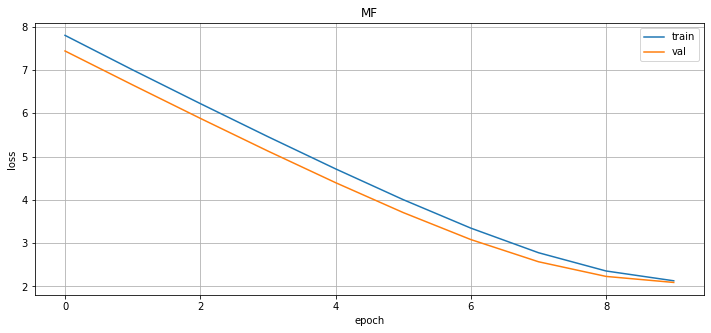

In [21]:
plot_losses(train_losses, val_losses, title="MF")

### Валидация модели

In [41]:
num_epochs = 20
batch_size = 128
lr = 3e-4

In [42]:
cv = KFold(n_splits = 3)

In [43]:
mean_KFold_losses = []
for k in [8, 10, 12]:
    val_losses_KFold = []
    train_losses_KFold = []
    models_KFold = list(np.zeros(cv.get_n_splits()))
    i = 0

    for train_index, test_index in cv.split(dataframe.drop(columns = ['rating','ts'])):
        x_train, x_test = dataframe.drop(columns = ['rating','ts']).iloc[train_index], dataframe.drop(columns = ['rating','ts']).iloc[test_index]
        y_train, y_test = dataframe['rating'].iloc[train_index], dataframe['rating'].iloc[test_index]
        
        TrainDataset = RatingsDataset(x_train.reset_index(drop = True), y_train.reset_index(drop = True))
        ValDataset = RatingsDataset(x_test.reset_index(drop = True), y_test.reset_index(drop = True))
        
        dataloader_train = DataLoader(TrainDataset, 
                                  collate_fn=RatingsDataset.collate, 
                                  batch_size=batch_size, shuffle=True, drop_last=True, 
                                  num_workers=4, pin_memory=True)

        dataloader_val = DataLoader(ValDataset, 
                                collate_fn=RatingsDataset.collate, 
                                batch_size=batch_size, shuffle=False, drop_last=False, 
                                num_workers=4, pin_memory=True)
        
        models_KFold[i] = MF(n_users, n_items, n_factors = k, activation = True, dropout = True)

        optimizer = torch.optim.Adam(models_KFold[i].parameters(), lr = lr)

        scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1, verbose=True)
        
        train_losses, val_losses, best_val_loss, models_KFold[i] = run_experiment(
        models_KFold[i], dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints/")
        
        train_losses_KFold.append(train_losses[-1])
        val_losses_KFold.append(best_val_loss)
        
        i += 1

    mean_KFold_losses.append(np.mean(val_losses_KFold))
    

epoch: 000 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.57it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.29it/s]


epoch: 000 | train_loss: 8.156, val_loss: 7.874 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=7.874.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.60it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.20it/s]


epoch: 001 | train_loss: 7.497, val_loss: 7.218 (best: 7.874)
New checkpoint saved to checkpoints/epoch=01_valloss=7.218.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.53it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 318.54it/s]


epoch: 002 | train_loss: 6.843, val_loss: 6.569 (best: 7.218)
New checkpoint saved to checkpoints/epoch=02_valloss=6.569.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:11<00:00, 196.68it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.68it/s]


epoch: 003 | train_loss: 6.197, val_loss: 5.927 (best: 6.569)
New checkpoint saved to checkpoints/epoch=03_valloss=5.927.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:12<00:00, 183.05it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.95it/s]


epoch: 004 | train_loss: 5.560, val_loss: 5.297 (best: 5.927)
New checkpoint saved to checkpoints/epoch=04_valloss=5.297.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.45it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.36it/s]


epoch: 005 | train_loss: 4.937, val_loss: 4.684 (best: 5.297)
New checkpoint saved to checkpoints/epoch=05_valloss=4.684.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.51it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.00it/s]


epoch: 006 | train_loss: 4.333, val_loss: 4.094 (best: 4.684)
New checkpoint saved to checkpoints/epoch=06_valloss=4.094.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.68it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.26it/s]


epoch: 007 | train_loss: 3.759, val_loss: 3.540 (best: 4.094)
New checkpoint saved to checkpoints/epoch=07_valloss=3.540.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.65it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.10it/s]


epoch: 008 | train_loss: 3.229, val_loss: 3.040 (best: 3.540)
New checkpoint saved to checkpoints/epoch=08_valloss=3.040.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.57it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.76it/s]


epoch: 009 | train_loss: 2.767, val_loss: 2.624 (best: 3.040)
New checkpoint saved to checkpoints/epoch=09_valloss=2.624.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:11<00:00, 197.71it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 304.80it/s]


epoch: 010 | train_loss: 2.409, val_loss: 2.326 (best: 2.624)
New checkpoint saved to checkpoints/epoch=10_valloss=2.326.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:10<00:00, 218.90it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 317.17it/s]


epoch: 011 | train_loss: 2.185, val_loss: 2.168 (best: 2.326)
New checkpoint saved to checkpoints/epoch=11_valloss=2.168.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:10<00:00, 216.80it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 248.37it/s]


epoch: 012 | train_loss: 2.095, val_loss: 2.124 (best: 2.168)
New checkpoint saved to checkpoints/epoch=12_valloss=2.124.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.55it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 257.65it/s]


epoch: 013 | train_loss: 2.080, val_loss: 2.120 (best: 2.124)
New checkpoint saved to checkpoints/epoch=13_valloss=2.120.pth.tar



epoch: 014 | train: 100%|██████████| 2285/2285 [00:11<00:00, 194.92it/s]
epoch: 014 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 233.04it/s]


epoch: 014 | train_loss: 2.080, val_loss: 2.120 (best: 2.120)
New checkpoint saved to checkpoints/epoch=14_valloss=2.120.pth.tar



epoch: 015 | train: 100%|██████████| 2285/2285 [00:13<00:00, 172.02it/s]
epoch: 015 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 304.95it/s]


epoch: 015 | train_loss: 2.080, val_loss: 2.120 (best: 2.120)
New checkpoint saved to checkpoints/epoch=15_valloss=2.120.pth.tar



epoch: 016 | train: 100%|██████████| 2285/2285 [00:10<00:00, 218.49it/s]


Epoch 00017: reducing learning rate of group 0 to 1.5000e-04.


epoch: 016 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.49it/s]


epoch: 016 | train_loss: 2.080, val_loss: 2.120 (best: 2.120)
New checkpoint saved to checkpoints/epoch=16_valloss=2.120.pth.tar



epoch: 017 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.13it/s]
epoch: 017 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 307.47it/s]


epoch: 017 | train_loss: 2.080, val_loss: 2.120 (best: 2.120)



epoch: 018 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.07it/s]
epoch: 018 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 299.48it/s]


epoch: 018 | train_loss: 2.080, val_loss: 2.120 (best: 2.120)



epoch: 019 | train: 100%|██████████| 2285/2285 [00:10<00:00, 217.01it/s]
epoch: 019 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 302.64it/s]


epoch: 019 | train_loss: 2.080, val_loss: 2.120 (best: 2.120)

Best val_loss = 2.120 reached at epoch 16


epoch: 000 | train: 100%|██████████| 2285/2285 [00:10<00:00, 218.54it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 304.54it/s]


epoch: 000 | train_loss: 8.256, val_loss: 7.891 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=7.891.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.50it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 308.40it/s]


epoch: 001 | train_loss: 7.595, val_loss: 7.236 (best: 7.891)
New checkpoint saved to checkpoints/epoch=01_valloss=7.236.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.02it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 306.68it/s]


epoch: 002 | train_loss: 6.940, val_loss: 6.587 (best: 7.236)
New checkpoint saved to checkpoints/epoch=02_valloss=6.587.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:12<00:00, 177.74it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.02it/s]


epoch: 003 | train_loss: 6.291, val_loss: 5.948 (best: 6.587)
New checkpoint saved to checkpoints/epoch=03_valloss=5.948.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.76it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 316.20it/s]


epoch: 004 | train_loss: 5.652, val_loss: 5.320 (best: 5.948)
New checkpoint saved to checkpoints/epoch=04_valloss=5.320.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.73it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.84it/s]


epoch: 005 | train_loss: 5.025, val_loss: 4.708 (best: 5.320)
New checkpoint saved to checkpoints/epoch=05_valloss=4.708.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.69it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.87it/s]


epoch: 006 | train_loss: 4.416, val_loss: 4.121 (best: 4.708)
New checkpoint saved to checkpoints/epoch=06_valloss=4.121.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.68it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.55it/s]


epoch: 007 | train_loss: 3.835, val_loss: 3.570 (best: 4.121)
New checkpoint saved to checkpoints/epoch=07_valloss=3.570.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.49it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.35it/s]


epoch: 008 | train_loss: 3.294, val_loss: 3.074 (best: 3.570)
New checkpoint saved to checkpoints/epoch=08_valloss=3.074.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.91it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.16it/s]


epoch: 009 | train_loss: 2.817, val_loss: 2.660 (best: 3.074)
New checkpoint saved to checkpoints/epoch=09_valloss=2.660.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.10it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.55it/s]


epoch: 010 | train_loss: 2.437, val_loss: 2.366 (best: 2.660)
New checkpoint saved to checkpoints/epoch=10_valloss=2.366.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.56it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 317.17it/s]


epoch: 011 | train_loss: 2.189, val_loss: 2.212 (best: 2.366)
New checkpoint saved to checkpoints/epoch=11_valloss=2.212.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.36it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.18it/s]


epoch: 012 | train_loss: 2.079, val_loss: 2.173 (best: 2.212)
New checkpoint saved to checkpoints/epoch=12_valloss=2.173.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.20it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.59it/s]


epoch: 013 | train_loss: 2.058, val_loss: 2.173 (best: 2.173)
New checkpoint saved to checkpoints/epoch=13_valloss=2.173.pth.tar



epoch: 014 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.29it/s]
epoch: 014 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.15it/s]


epoch: 014 | train_loss: 2.056, val_loss: 2.173 (best: 2.173)



epoch: 015 | train: 100%|██████████| 2285/2285 [00:10<00:00, 219.38it/s]
epoch: 015 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 308.97it/s]


epoch: 015 | train_loss: 2.056, val_loss: 2.173 (best: 2.173)



epoch: 016 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.51it/s]
epoch: 016 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.59it/s]


epoch: 016 | train_loss: 2.056, val_loss: 2.173 (best: 2.173)



epoch: 017 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.81it/s]


Epoch 00018: reducing learning rate of group 0 to 1.5000e-04.


epoch: 017 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 317.80it/s]


epoch: 017 | train_loss: 2.056, val_loss: 2.173 (best: 2.173)



epoch: 018 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.99it/s]
epoch: 018 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 305.77it/s]


epoch: 018 | train_loss: 2.056, val_loss: 2.173 (best: 2.173)



epoch: 019 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.21it/s]


Epoch 00020: reducing learning rate of group 0 to 7.5000e-05.


epoch: 019 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 316.81it/s]


epoch: 019 | train_loss: 2.056, val_loss: 2.173 (best: 2.173)

Best val_loss = 2.173 reached at epoch 13


epoch: 000 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.53it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 317.92it/s]


epoch: 000 | train_loss: 8.099, val_loss: 7.812 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=7.812.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.14it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.65it/s]


epoch: 001 | train_loss: 7.439, val_loss: 7.158 (best: 7.812)
New checkpoint saved to checkpoints/epoch=01_valloss=7.158.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.14it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.62it/s]


epoch: 002 | train_loss: 6.786, val_loss: 6.510 (best: 7.158)
New checkpoint saved to checkpoints/epoch=02_valloss=6.510.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:11<00:00, 192.73it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 246.95it/s]


epoch: 003 | train_loss: 6.139, val_loss: 5.871 (best: 6.510)
New checkpoint saved to checkpoints/epoch=03_valloss=5.871.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.38it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 317.67it/s]


epoch: 004 | train_loss: 5.503, val_loss: 5.245 (best: 5.871)
New checkpoint saved to checkpoints/epoch=04_valloss=5.245.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.99it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.26it/s]


epoch: 005 | train_loss: 4.881, val_loss: 4.636 (best: 5.245)
New checkpoint saved to checkpoints/epoch=05_valloss=4.636.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.60it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.40it/s]


epoch: 006 | train_loss: 4.278, val_loss: 4.052 (best: 4.636)
New checkpoint saved to checkpoints/epoch=06_valloss=4.052.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:12<00:00, 186.58it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 288.19it/s]


epoch: 007 | train_loss: 3.706, val_loss: 3.506 (best: 4.052)
New checkpoint saved to checkpoints/epoch=07_valloss=3.506.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.72it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.50it/s]


epoch: 008 | train_loss: 3.179, val_loss: 3.017 (best: 3.506)
New checkpoint saved to checkpoints/epoch=08_valloss=3.017.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.34it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.89it/s]


epoch: 009 | train_loss: 2.723, val_loss: 2.616 (best: 3.017)
New checkpoint saved to checkpoints/epoch=09_valloss=2.616.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.65it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.48it/s]


epoch: 010 | train_loss: 2.374, val_loss: 2.337 (best: 2.616)
New checkpoint saved to checkpoints/epoch=10_valloss=2.337.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.44it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 307.69it/s]


epoch: 011 | train_loss: 2.161, val_loss: 2.198 (best: 2.337)
New checkpoint saved to checkpoints/epoch=11_valloss=2.198.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.29it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.65it/s]


epoch: 012 | train_loss: 2.079, val_loss: 2.163 (best: 2.198)
New checkpoint saved to checkpoints/epoch=12_valloss=2.163.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.47it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.01it/s]


epoch: 013 | train_loss: 2.068, val_loss: 2.161 (best: 2.163)
New checkpoint saved to checkpoints/epoch=13_valloss=2.161.pth.tar



epoch: 014 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.80it/s]
epoch: 014 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.34it/s]


epoch: 014 | train_loss: 2.067, val_loss: 2.161 (best: 2.161)
New checkpoint saved to checkpoints/epoch=14_valloss=2.161.pth.tar



epoch: 015 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.00it/s]
epoch: 015 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.44it/s]


epoch: 015 | train_loss: 2.067, val_loss: 2.161 (best: 2.161)



epoch: 016 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.91it/s]


Epoch 00017: reducing learning rate of group 0 to 1.5000e-04.


epoch: 016 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.67it/s]


epoch: 016 | train_loss: 2.067, val_loss: 2.161 (best: 2.161)



epoch: 017 | train: 100%|██████████| 2285/2285 [00:10<00:00, 219.12it/s]
epoch: 017 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.41it/s]


epoch: 017 | train_loss: 2.067, val_loss: 2.161 (best: 2.161)



epoch: 018 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.57it/s]


Epoch 00019: reducing learning rate of group 0 to 7.5000e-05.


epoch: 018 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 308.24it/s]


epoch: 018 | train_loss: 2.067, val_loss: 2.161 (best: 2.161)



epoch: 019 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.23it/s]
epoch: 019 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.83it/s]


epoch: 019 | train_loss: 2.067, val_loss: 2.161 (best: 2.161)

Best val_loss = 2.161 reached at epoch 14


epoch: 000 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.98it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.01it/s]


epoch: 000 | train_loss: 7.809, val_loss: 7.522 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=7.522.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.51it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.38it/s]


epoch: 001 | train_loss: 7.152, val_loss: 6.867 (best: 7.522)
New checkpoint saved to checkpoints/epoch=01_valloss=6.867.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.47it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.41it/s]


epoch: 002 | train_loss: 6.502, val_loss: 6.221 (best: 6.867)
New checkpoint saved to checkpoints/epoch=02_valloss=6.221.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.48it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 308.77it/s]


epoch: 003 | train_loss: 5.861, val_loss: 5.584 (best: 6.221)
New checkpoint saved to checkpoints/epoch=03_valloss=5.584.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:13<00:00, 175.71it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.35it/s]


epoch: 004 | train_loss: 5.230, val_loss: 4.960 (best: 5.584)
New checkpoint saved to checkpoints/epoch=04_valloss=4.960.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.16it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.26it/s]


epoch: 005 | train_loss: 4.616, val_loss: 4.355 (best: 4.960)
New checkpoint saved to checkpoints/epoch=05_valloss=4.355.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.07it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.24it/s]


epoch: 006 | train_loss: 4.027, val_loss: 3.779 (best: 4.355)
New checkpoint saved to checkpoints/epoch=06_valloss=3.779.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.95it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 316.20it/s]


epoch: 007 | train_loss: 3.473, val_loss: 3.247 (best: 3.779)
New checkpoint saved to checkpoints/epoch=07_valloss=3.247.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.77it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 316.59it/s]


epoch: 008 | train_loss: 2.976, val_loss: 2.783 (best: 3.247)
New checkpoint saved to checkpoints/epoch=08_valloss=2.783.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.99it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.61it/s]


epoch: 009 | train_loss: 2.564, val_loss: 2.420 (best: 2.783)
New checkpoint saved to checkpoints/epoch=09_valloss=2.420.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.49it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.66it/s]


epoch: 010 | train_loss: 2.273, val_loss: 2.192 (best: 2.420)
New checkpoint saved to checkpoints/epoch=10_valloss=2.192.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.74it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 316.88it/s]


epoch: 011 | train_loss: 2.124, val_loss: 2.099 (best: 2.192)
New checkpoint saved to checkpoints/epoch=11_valloss=2.099.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.45it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.57it/s]


epoch: 012 | train_loss: 2.083, val_loss: 2.084 (best: 2.099)
New checkpoint saved to checkpoints/epoch=12_valloss=2.084.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.40it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.41it/s]


epoch: 013 | train_loss: 2.080, val_loss: 2.083 (best: 2.084)
New checkpoint saved to checkpoints/epoch=13_valloss=2.083.pth.tar



epoch: 014 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.44it/s]
epoch: 014 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.31it/s]


epoch: 014 | train_loss: 2.080, val_loss: 2.083 (best: 2.083)
New checkpoint saved to checkpoints/epoch=14_valloss=2.083.pth.tar



epoch: 015 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.63it/s]


Epoch 00016: reducing learning rate of group 0 to 1.5000e-04.


epoch: 015 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.13it/s]


epoch: 015 | train_loss: 2.080, val_loss: 2.083 (best: 2.083)
New checkpoint saved to checkpoints/epoch=15_valloss=2.083.pth.tar



epoch: 016 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.49it/s]
epoch: 016 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.34it/s]


epoch: 016 | train_loss: 2.080, val_loss: 2.083 (best: 2.083)



epoch: 017 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.78it/s]
epoch: 017 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 305.13it/s]


epoch: 017 | train_loss: 2.080, val_loss: 2.083 (best: 2.083)



epoch: 018 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.94it/s]


Epoch 00019: reducing learning rate of group 0 to 7.5000e-05.


epoch: 018 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 318.36it/s]


epoch: 018 | train_loss: 2.080, val_loss: 2.083 (best: 2.083)



epoch: 019 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.69it/s]
epoch: 019 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 308.89it/s]


epoch: 019 | train_loss: 2.080, val_loss: 2.083 (best: 2.083)

Best val_loss = 2.083 reached at epoch 15


epoch: 000 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.12it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.86it/s]


epoch: 000 | train_loss: 8.425, val_loss: 8.066 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=8.066.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:10<00:00, 226.70it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.57it/s]


epoch: 001 | train_loss: 7.764, val_loss: 7.410 (best: 8.066)
New checkpoint saved to checkpoints/epoch=01_valloss=7.410.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.29it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.23it/s]


epoch: 002 | train_loss: 7.107, val_loss: 6.761 (best: 7.410)
New checkpoint saved to checkpoints/epoch=02_valloss=6.761.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.08it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 317.20it/s]


epoch: 003 | train_loss: 6.456, val_loss: 6.119 (best: 6.761)
New checkpoint saved to checkpoints/epoch=03_valloss=6.119.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.43it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.63it/s]


epoch: 004 | train_loss: 5.814, val_loss: 5.488 (best: 6.119)
New checkpoint saved to checkpoints/epoch=04_valloss=5.488.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:12<00:00, 176.27it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.33it/s]


epoch: 005 | train_loss: 5.184, val_loss: 4.873 (best: 5.488)
New checkpoint saved to checkpoints/epoch=05_valloss=4.873.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.74it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.31it/s]


epoch: 006 | train_loss: 4.570, val_loss: 4.280 (best: 4.873)
New checkpoint saved to checkpoints/epoch=06_valloss=4.280.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:10<00:00, 227.00it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.76it/s]


epoch: 007 | train_loss: 3.980, val_loss: 3.719 (best: 4.280)
New checkpoint saved to checkpoints/epoch=07_valloss=3.719.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.68it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.68it/s]


epoch: 008 | train_loss: 3.427, val_loss: 3.208 (best: 3.719)
New checkpoint saved to checkpoints/epoch=08_valloss=3.208.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.58it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.89it/s]


epoch: 009 | train_loss: 2.931, val_loss: 2.772 (best: 3.208)
New checkpoint saved to checkpoints/epoch=09_valloss=2.772.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:10<00:00, 226.03it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.71it/s]


epoch: 010 | train_loss: 2.523, val_loss: 2.445 (best: 2.772)
New checkpoint saved to checkpoints/epoch=10_valloss=2.445.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.55it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.29it/s]


epoch: 011 | train_loss: 2.238, val_loss: 2.256 (best: 2.445)
New checkpoint saved to checkpoints/epoch=11_valloss=2.256.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.57it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.79it/s]


epoch: 012 | train_loss: 2.096, val_loss: 2.194 (best: 2.256)
New checkpoint saved to checkpoints/epoch=12_valloss=2.194.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.44it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.94it/s]


epoch: 013 | train_loss: 2.059, val_loss: 2.190 (best: 2.194)
New checkpoint saved to checkpoints/epoch=13_valloss=2.190.pth.tar



epoch: 014 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.51it/s]
epoch: 014 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.67it/s]


epoch: 014 | train_loss: 2.057, val_loss: 2.190 (best: 2.190)



epoch: 015 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.15it/s]
epoch: 015 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.51it/s]


epoch: 015 | train_loss: 2.057, val_loss: 2.190 (best: 2.190)



epoch: 016 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.15it/s]


Epoch 00017: reducing learning rate of group 0 to 1.5000e-04.


epoch: 016 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 318.49it/s]


epoch: 016 | train_loss: 2.057, val_loss: 2.190 (best: 2.190)



epoch: 017 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.47it/s]
epoch: 017 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.98it/s]


epoch: 017 | train_loss: 2.056, val_loss: 2.190 (best: 2.190)



epoch: 018 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.37it/s]
epoch: 018 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 317.13it/s]


epoch: 018 | train_loss: 2.056, val_loss: 2.191 (best: 2.190)



epoch: 019 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.16it/s]
epoch: 019 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.36it/s]


epoch: 019 | train_loss: 2.056, val_loss: 2.191 (best: 2.190)

Best val_loss = 2.190 reached at epoch 13


epoch: 000 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.38it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.73it/s]


epoch: 000 | train_loss: 7.870, val_loss: 7.577 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=7.577.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.34it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 304.97it/s]


epoch: 001 | train_loss: 7.213, val_loss: 6.924 (best: 7.577)
New checkpoint saved to checkpoints/epoch=01_valloss=6.924.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.58it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.84it/s]


epoch: 002 | train_loss: 6.561, val_loss: 6.278 (best: 6.924)
New checkpoint saved to checkpoints/epoch=02_valloss=6.278.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.73it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.43it/s]


epoch: 003 | train_loss: 5.918, val_loss: 5.642 (best: 6.278)
New checkpoint saved to checkpoints/epoch=03_valloss=5.642.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.41it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.59it/s]


epoch: 004 | train_loss: 5.286, val_loss: 5.019 (best: 5.642)
New checkpoint saved to checkpoints/epoch=04_valloss=5.019.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.51it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:05<00:00, 200.63it/s]


epoch: 005 | train_loss: 4.670, val_loss: 4.416 (best: 5.019)
New checkpoint saved to checkpoints/epoch=05_valloss=4.416.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:11<00:00, 202.37it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.93it/s]


epoch: 006 | train_loss: 4.076, val_loss: 3.841 (best: 4.416)
New checkpoint saved to checkpoints/epoch=06_valloss=3.841.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.82it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.66it/s]


epoch: 007 | train_loss: 3.517, val_loss: 3.309 (best: 3.841)
New checkpoint saved to checkpoints/epoch=07_valloss=3.309.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.18it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 318.62it/s]


epoch: 008 | train_loss: 3.012, val_loss: 2.844 (best: 3.309)
New checkpoint saved to checkpoints/epoch=08_valloss=2.844.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.09it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 317.94it/s]


epoch: 009 | train_loss: 2.588, val_loss: 2.478 (best: 2.844)
New checkpoint saved to checkpoints/epoch=09_valloss=2.478.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.94it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.04it/s]


epoch: 010 | train_loss: 2.284, val_loss: 2.245 (best: 2.478)
New checkpoint saved to checkpoints/epoch=10_valloss=2.245.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.48it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.65it/s]


epoch: 011 | train_loss: 2.120, val_loss: 2.147 (best: 2.245)
New checkpoint saved to checkpoints/epoch=11_valloss=2.147.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.80it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.09it/s]


epoch: 012 | train_loss: 2.071, val_loss: 2.130 (best: 2.147)
New checkpoint saved to checkpoints/epoch=12_valloss=2.130.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.52it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.58it/s]


epoch: 013 | train_loss: 2.067, val_loss: 2.130 (best: 2.130)
New checkpoint saved to checkpoints/epoch=13_valloss=2.130.pth.tar



epoch: 014 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.49it/s]
epoch: 014 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.55it/s]


epoch: 014 | train_loss: 2.067, val_loss: 2.130 (best: 2.130)
New checkpoint saved to checkpoints/epoch=14_valloss=2.130.pth.tar



epoch: 015 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.49it/s]
epoch: 015 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 316.09it/s]


epoch: 015 | train_loss: 2.067, val_loss: 2.129 (best: 2.130)
New checkpoint saved to checkpoints/epoch=15_valloss=2.129.pth.tar



epoch: 016 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.96it/s]


Epoch 00017: reducing learning rate of group 0 to 1.5000e-04.


epoch: 016 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.99it/s]


epoch: 016 | train_loss: 2.067, val_loss: 2.129 (best: 2.129)
New checkpoint saved to checkpoints/epoch=16_valloss=2.129.pth.tar



epoch: 017 | train: 100%|██████████| 2285/2285 [00:10<00:00, 225.12it/s]
epoch: 017 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.09it/s]


epoch: 017 | train_loss: 2.067, val_loss: 2.129 (best: 2.129)



epoch: 018 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.53it/s]


Epoch 00019: reducing learning rate of group 0 to 7.5000e-05.


epoch: 018 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.93it/s]


epoch: 018 | train_loss: 2.067, val_loss: 2.130 (best: 2.129)



epoch: 019 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.07it/s]
epoch: 019 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.75it/s]


epoch: 019 | train_loss: 2.067, val_loss: 2.129 (best: 2.129)

Best val_loss = 2.129 reached at epoch 16


epoch: 000 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.73it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 317.78it/s]


epoch: 000 | train_loss: 7.944, val_loss: 7.672 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=7.672.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.44it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 318.98it/s]


epoch: 001 | train_loss: 7.286, val_loss: 7.019 (best: 7.672)
New checkpoint saved to checkpoints/epoch=01_valloss=7.019.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.68it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.57it/s]


epoch: 002 | train_loss: 6.635, val_loss: 6.372 (best: 7.019)
New checkpoint saved to checkpoints/epoch=02_valloss=6.372.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:10<00:00, 219.18it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 305.22it/s]


epoch: 003 | train_loss: 5.991, val_loss: 5.735 (best: 6.372)
New checkpoint saved to checkpoints/epoch=03_valloss=5.735.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:10<00:00, 218.89it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.94it/s]


epoch: 004 | train_loss: 5.358, val_loss: 5.110 (best: 5.735)
New checkpoint saved to checkpoints/epoch=04_valloss=5.110.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.82it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 300.48it/s]


epoch: 005 | train_loss: 4.741, val_loss: 4.504 (best: 5.110)
New checkpoint saved to checkpoints/epoch=05_valloss=4.504.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:10<00:00, 211.49it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:06<00:00, 189.91it/s]


epoch: 006 | train_loss: 4.145, val_loss: 3.926 (best: 4.504)
New checkpoint saved to checkpoints/epoch=06_valloss=3.926.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:10<00:00, 219.37it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.25it/s]


epoch: 007 | train_loss: 3.583, val_loss: 3.388 (best: 3.926)
New checkpoint saved to checkpoints/epoch=07_valloss=3.388.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.92it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.98it/s]


epoch: 008 | train_loss: 3.072, val_loss: 2.914 (best: 3.388)
New checkpoint saved to checkpoints/epoch=08_valloss=2.914.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.93it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.20it/s]


epoch: 009 | train_loss: 2.639, val_loss: 2.533 (best: 2.914)
New checkpoint saved to checkpoints/epoch=09_valloss=2.533.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.48it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.15it/s]


epoch: 010 | train_loss: 2.321, val_loss: 2.280 (best: 2.533)
New checkpoint saved to checkpoints/epoch=10_valloss=2.280.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.16it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.05it/s]


epoch: 011 | train_loss: 2.143, val_loss: 2.166 (best: 2.280)
New checkpoint saved to checkpoints/epoch=11_valloss=2.166.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.01it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.88it/s]


epoch: 012 | train_loss: 2.086, val_loss: 2.142 (best: 2.166)
New checkpoint saved to checkpoints/epoch=12_valloss=2.142.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:10<00:00, 219.28it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.96it/s]


epoch: 013 | train_loss: 2.080, val_loss: 2.141 (best: 2.142)
New checkpoint saved to checkpoints/epoch=13_valloss=2.141.pth.tar



epoch: 014 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.86it/s]
epoch: 014 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 301.56it/s]


epoch: 014 | train_loss: 2.080, val_loss: 2.141 (best: 2.141)
New checkpoint saved to checkpoints/epoch=14_valloss=2.141.pth.tar



epoch: 015 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.01it/s]
epoch: 015 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.81it/s]


epoch: 015 | train_loss: 2.080, val_loss: 2.141 (best: 2.141)



epoch: 016 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.79it/s]


Epoch 00017: reducing learning rate of group 0 to 1.5000e-04.


epoch: 016 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 308.07it/s]


epoch: 016 | train_loss: 2.080, val_loss: 2.141 (best: 2.141)



epoch: 017 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.67it/s]
epoch: 017 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.24it/s]


epoch: 017 | train_loss: 2.080, val_loss: 2.141 (best: 2.141)



epoch: 018 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.70it/s]


Epoch 00019: reducing learning rate of group 0 to 7.5000e-05.


epoch: 018 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.95it/s]


epoch: 018 | train_loss: 2.080, val_loss: 2.141 (best: 2.141)



epoch: 019 | train: 100%|██████████| 2285/2285 [00:10<00:00, 219.81it/s]
epoch: 019 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.49it/s]


epoch: 019 | train_loss: 2.080, val_loss: 2.141 (best: 2.141)

Best val_loss = 2.141 reached at epoch 14


epoch: 000 | train: 100%|██████████| 2285/2285 [00:10<00:00, 219.30it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 307.45it/s]


epoch: 000 | train_loss: 8.095, val_loss: 7.726 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=7.726.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.41it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 315.81it/s]


epoch: 001 | train_loss: 7.436, val_loss: 7.072 (best: 7.726)
New checkpoint saved to checkpoints/epoch=01_valloss=7.072.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.71it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.59it/s]


epoch: 002 | train_loss: 6.782, val_loss: 6.425 (best: 7.072)
New checkpoint saved to checkpoints/epoch=02_valloss=6.425.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.98it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.93it/s]


epoch: 003 | train_loss: 6.135, val_loss: 5.787 (best: 6.425)
New checkpoint saved to checkpoints/epoch=03_valloss=5.787.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.97it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.96it/s]


epoch: 004 | train_loss: 5.499, val_loss: 5.161 (best: 5.787)
New checkpoint saved to checkpoints/epoch=04_valloss=5.161.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:10<00:00, 217.50it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 300.70it/s]


epoch: 005 | train_loss: 4.876, val_loss: 4.553 (best: 5.161)
New checkpoint saved to checkpoints/epoch=05_valloss=4.553.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:10<00:00, 218.86it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.16it/s]


epoch: 006 | train_loss: 4.272, val_loss: 3.971 (best: 4.553)
New checkpoint saved to checkpoints/epoch=06_valloss=3.971.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:12<00:00, 176.53it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.82it/s]


epoch: 007 | train_loss: 3.699, val_loss: 3.429 (best: 3.971)
New checkpoint saved to checkpoints/epoch=07_valloss=3.429.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.70it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.84it/s]


epoch: 008 | train_loss: 3.171, val_loss: 2.946 (best: 3.429)
New checkpoint saved to checkpoints/epoch=08_valloss=2.946.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:10<00:00, 219.69it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 308.10it/s]


epoch: 009 | train_loss: 2.715, val_loss: 2.555 (best: 2.946)
New checkpoint saved to checkpoints/epoch=09_valloss=2.555.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.58it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.34it/s]


epoch: 010 | train_loss: 2.364, val_loss: 2.291 (best: 2.555)
New checkpoint saved to checkpoints/epoch=10_valloss=2.291.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.40it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.68it/s]


epoch: 011 | train_loss: 2.150, val_loss: 2.167 (best: 2.291)
New checkpoint saved to checkpoints/epoch=11_valloss=2.167.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.86it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.08it/s]


epoch: 012 | train_loss: 2.069, val_loss: 2.144 (best: 2.167)
New checkpoint saved to checkpoints/epoch=12_valloss=2.144.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.43it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 306.07it/s]


epoch: 013 | train_loss: 2.057, val_loss: 2.145 (best: 2.144)



epoch: 014 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.07it/s]
epoch: 014 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.35it/s]


epoch: 014 | train_loss: 2.056, val_loss: 2.145 (best: 2.144)



epoch: 015 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.11it/s]
epoch: 015 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.56it/s]


epoch: 015 | train_loss: 2.057, val_loss: 2.145 (best: 2.144)



epoch: 016 | train: 100%|██████████| 2285/2285 [00:10<00:00, 219.50it/s]


Epoch 00017: reducing learning rate of group 0 to 1.5000e-04.


epoch: 016 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.14it/s]


epoch: 016 | train_loss: 2.056, val_loss: 2.145 (best: 2.144)



epoch: 017 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.25it/s]
epoch: 017 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.44it/s]


epoch: 017 | train_loss: 2.056, val_loss: 2.145 (best: 2.144)



epoch: 018 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.96it/s]


Epoch 00019: reducing learning rate of group 0 to 7.5000e-05.


epoch: 018 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.81it/s]


epoch: 018 | train_loss: 2.056, val_loss: 2.145 (best: 2.144)



epoch: 019 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.30it/s]
epoch: 019 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.28it/s]


epoch: 019 | train_loss: 2.057, val_loss: 2.145 (best: 2.144)

Best val_loss = 2.144 reached at epoch 12


epoch: 000 | train: 100%|██████████| 2285/2285 [00:10<00:00, 223.12it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 316.58it/s]


epoch: 000 | train_loss: 8.373, val_loss: 8.075 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=8.075.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:10<00:00, 224.07it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.44it/s]


epoch: 001 | train_loss: 7.712, val_loss: 7.418 (best: 8.075)
New checkpoint saved to checkpoints/epoch=01_valloss=7.418.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.06it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 307.49it/s]


epoch: 002 | train_loss: 7.056, val_loss: 6.766 (best: 7.418)
New checkpoint saved to checkpoints/epoch=02_valloss=6.766.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.56it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.47it/s]


epoch: 003 | train_loss: 6.406, val_loss: 6.122 (best: 6.766)
New checkpoint saved to checkpoints/epoch=03_valloss=6.122.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.35it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.50it/s]


epoch: 004 | train_loss: 5.766, val_loss: 5.488 (best: 6.122)
New checkpoint saved to checkpoints/epoch=04_valloss=5.488.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.86it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 312.27it/s]


epoch: 005 | train_loss: 5.137, val_loss: 4.869 (best: 5.488)
New checkpoint saved to checkpoints/epoch=05_valloss=4.869.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.29it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.86it/s]


epoch: 006 | train_loss: 4.525, val_loss: 4.272 (best: 4.869)
New checkpoint saved to checkpoints/epoch=06_valloss=4.272.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:10<00:00, 218.56it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 300.84it/s]


epoch: 007 | train_loss: 3.938, val_loss: 3.705 (best: 4.272)
New checkpoint saved to checkpoints/epoch=07_valloss=3.705.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:13<00:00, 174.82it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 309.52it/s]


epoch: 008 | train_loss: 3.390, val_loss: 3.186 (best: 3.705)
New checkpoint saved to checkpoints/epoch=08_valloss=3.186.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:10<00:00, 219.40it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.26it/s]


epoch: 009 | train_loss: 2.902, val_loss: 2.741 (best: 3.186)
New checkpoint saved to checkpoints/epoch=09_valloss=2.741.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.88it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.39it/s]


epoch: 010 | train_loss: 2.503, val_loss: 2.403 (best: 2.741)
New checkpoint saved to checkpoints/epoch=10_valloss=2.403.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.15it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 314.44it/s]


epoch: 011 | train_loss: 2.231, val_loss: 2.204 (best: 2.403)
New checkpoint saved to checkpoints/epoch=11_valloss=2.204.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.28it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 311.11it/s]


epoch: 012 | train_loss: 2.100, val_loss: 2.133 (best: 2.204)
New checkpoint saved to checkpoints/epoch=12_valloss=2.133.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.31it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.43it/s]


epoch: 013 | train_loss: 2.069, val_loss: 2.124 (best: 2.133)
New checkpoint saved to checkpoints/epoch=13_valloss=2.124.pth.tar



epoch: 014 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.90it/s]
epoch: 014 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 308.47it/s]


epoch: 014 | train_loss: 2.068, val_loss: 2.124 (best: 2.124)
New checkpoint saved to checkpoints/epoch=14_valloss=2.124.pth.tar



epoch: 015 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.76it/s]
epoch: 015 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 302.02it/s]


epoch: 015 | train_loss: 2.067, val_loss: 2.124 (best: 2.124)
New checkpoint saved to checkpoints/epoch=15_valloss=2.124.pth.tar



epoch: 016 | train: 100%|██████████| 2285/2285 [00:10<00:00, 222.72it/s]
epoch: 016 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 313.80it/s]


epoch: 016 | train_loss: 2.067, val_loss: 2.124 (best: 2.124)



epoch: 017 | train: 100%|██████████| 2285/2285 [00:10<00:00, 220.53it/s]


Epoch 00018: reducing learning rate of group 0 to 1.5000e-04.


epoch: 017 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 307.02it/s]


epoch: 017 | train_loss: 2.067, val_loss: 2.124 (best: 2.124)



epoch: 018 | train: 100%|██████████| 2285/2285 [00:10<00:00, 221.38it/s]
epoch: 018 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 310.40it/s]


epoch: 018 | train_loss: 2.067, val_loss: 2.124 (best: 2.124)



epoch: 019 | train: 100%|██████████| 2285/2285 [00:10<00:00, 218.80it/s]


Epoch 00020: reducing learning rate of group 0 to 7.5000e-05.


epoch: 019 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 316.16it/s]

epoch: 019 | train_loss: 2.067, val_loss: 2.124 (best: 2.124)

Best val_loss = 2.124 reached at epoch 15


Посмотрим на средние значения RMSE по фолдам для 8, 10 и 12 факторов 

In [45]:
print(mean_KFold_losses)

[2.1510666903965534, 2.1340792924817573, 2.136099092568904]


Видим, что наилучшее качество получилось для модели с 10 факторами

Добавим в нейросеть линейные слои, которые будут преобразовывать другие эмбеддинги, а в конце соединим их с матричной факторизацией

In [29]:
class NeuMF(nn.Module):
    def __init__(self, n_users, n_items, n_factors_mf, n_factors_mlp, hidden_layers_sizes, activation, dropouts_mlp, dropout_mf):
        super().__init__()
        
        self.n_factors_mf = n_factors_mf
        self.n_factors_mlp = n_factors_mlp
        self.n_users = n_users
        self.n_items = n_items
        self.p = dropout_mf
        self.dropouts_mlp = dropouts_mlp
    
        # mf part
        self.u_emb_mf = nn.Embedding(self.n_users, self.n_factors_mf)
        self.i_emb_mf = nn.Embedding(self.n_items, self.n_factors_mf)

        self.dropout_mf = torch.nn.Dropout(self.p)
        
        # mlp part
        self.u_emb_mlp = nn.Embedding(self.n_users, self.n_factors_mlp)
        self.i_emb_mlp = nn.Embedding(self.n_items, self.n_factors_mlp)
        
        
        layers = [Block(2*n_factors_mlp, hidden_layers_sizes[0], activation = activation, dropout = dropouts_mlp[0])]
        
        for i in range(len(hidden_layers_sizes)-1):
            layers.append(Block(hidden_layers_sizes[i], hidden_layers_sizes[i+1], activation = activation, dropout = dropouts_mlp[i+1]))
              
        self.mlp = nn.Sequential(*layers)

        self.out_linear = torch.nn.Linear(in_features = hidden_layers_sizes[-1] + self.n_factors_mf, out_features = 1)

    def forward(self, users, items): 
        
        features_mf = torch.mul(self.u_emb_mf(users), self.i_emb_mf(items))
        features_mlp = torch.cat([self.u_emb_mlp(users), self.i_emb_mlp(items)], dim=-1)
        
        out_mlp = self.mlp(features_mlp)
        out_mf = self.dropout_mf(features_mf)

        out = torch.cat([out_mlp, out_mf], dim=-1)
        return self.out_linear(out)

Проверим, что модель обучается

In [30]:
TrainDataset = RatingsDataset(X_train, y_train)
ValDataset = RatingsDataset(X_test.reset_index(drop = True), y_test.reset_index(drop = True))

In [31]:
num_epochs = 10
batch_size = 128
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [32]:
dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

In [33]:
model = NeuMF(n_users, n_items, n_factors_mf = 10, n_factors_mlp = 10, hidden_layers_sizes = [16, 16], 
              activation = True, dropouts_mlp = [0.9,0.9], dropout_mf = 0.5)
loss_fn = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1, verbose=True)

In [27]:
train_losses, val_losses, best_val_loss, model = run_experiment(
    model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints/")

epoch: 000 | train: 100%|██████████| 2742/2742 [00:17<00:00, 160.02it/s]
epoch: 000 | val  : 100%|██████████| 686/686 [00:02<00:00, 271.65it/s]


epoch: 000 | train_loss: 6.518, val_loss: 3.943 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=3.943.pth.tar



epoch: 001 | train: 100%|██████████| 2742/2742 [00:17<00:00, 158.07it/s]
epoch: 001 | val  : 100%|██████████| 686/686 [00:02<00:00, 274.58it/s]


epoch: 001 | train_loss: 4.702, val_loss: 3.146 (best: 3.943)
New checkpoint saved to checkpoints/epoch=01_valloss=3.146.pth.tar



epoch: 002 | train: 100%|██████████| 2742/2742 [00:16<00:00, 161.40it/s]
epoch: 002 | val  : 100%|██████████| 686/686 [00:02<00:00, 278.13it/s]


epoch: 002 | train_loss: 4.224, val_loss: 2.942 (best: 3.146)
New checkpoint saved to checkpoints/epoch=02_valloss=2.942.pth.tar



epoch: 003 | train: 100%|██████████| 2742/2742 [00:16<00:00, 161.52it/s]
epoch: 003 | val  : 100%|██████████| 686/686 [00:02<00:00, 270.08it/s]


epoch: 003 | train_loss: 3.813, val_loss: 2.731 (best: 2.942)
New checkpoint saved to checkpoints/epoch=03_valloss=2.731.pth.tar



epoch: 004 | train: 100%|██████████| 2742/2742 [00:23<00:00, 116.00it/s]
epoch: 004 | val  : 100%|██████████| 686/686 [00:02<00:00, 274.75it/s]


epoch: 004 | train_loss: 3.416, val_loss: 2.587 (best: 2.731)
New checkpoint saved to checkpoints/epoch=04_valloss=2.587.pth.tar



epoch: 005 | train: 100%|██████████| 2742/2742 [00:17<00:00, 157.30it/s]
epoch: 005 | val  : 100%|██████████| 686/686 [00:02<00:00, 265.91it/s]


epoch: 005 | train_loss: 3.056, val_loss: 2.405 (best: 2.587)
New checkpoint saved to checkpoints/epoch=05_valloss=2.405.pth.tar



epoch: 006 | train: 100%|██████████| 2742/2742 [00:19<00:00, 139.41it/s]
epoch: 006 | val  : 100%|██████████| 686/686 [00:02<00:00, 275.73it/s]


epoch: 006 | train_loss: 2.731, val_loss: 2.281 (best: 2.405)
New checkpoint saved to checkpoints/epoch=06_valloss=2.281.pth.tar



epoch: 007 | train: 100%|██████████| 2742/2742 [00:20<00:00, 135.03it/s]
epoch: 007 | val  : 100%|██████████| 686/686 [00:02<00:00, 271.73it/s]


epoch: 007 | train_loss: 2.461, val_loss: 2.181 (best: 2.281)
New checkpoint saved to checkpoints/epoch=07_valloss=2.181.pth.tar



epoch: 008 | train: 100%|██████████| 2742/2742 [00:17<00:00, 153.16it/s]
epoch: 008 | val  : 100%|██████████| 686/686 [00:03<00:00, 218.36it/s]


epoch: 008 | train_loss: 2.259, val_loss: 2.123 (best: 2.181)
New checkpoint saved to checkpoints/epoch=08_valloss=2.123.pth.tar



epoch: 009 | train: 100%|██████████| 2742/2742 [00:20<00:00, 136.60it/s]
epoch: 009 | val  : 100%|██████████| 686/686 [00:02<00:00, 268.98it/s]

epoch: 009 | train_loss: 2.134, val_loss: 2.085 (best: 2.123)
New checkpoint saved to checkpoints/epoch=09_valloss=2.085.pth.tar

Best val_loss = 2.085 reached at epoch 9


### Валидация модели

In [28]:
num_epochs = 14
batch_size = 128
lr = 3e-4

In [29]:
cv = KFold(n_splits = 3)

In [30]:
mean_KFold_losses = []
for k in [8, 10, 12]:
    val_losses_KFold = []
    train_losses_KFold = []
    models_KFold = list(np.zeros(cv.get_n_splits()))
    i = 0

    for train_index, test_index in cv.split(dataframe.drop(columns = ['rating','ts'])):
        x_train, x_test = dataframe.drop(columns = ['rating','ts']).iloc[train_index], dataframe.drop(columns = ['rating','ts']).iloc[test_index]
        y_train, y_test = dataframe['rating'].iloc[train_index], dataframe['rating'].iloc[test_index]
        
        TrainDataset = RatingsDataset(x_train.reset_index(drop = True), y_train.reset_index(drop = True))
        ValDataset = RatingsDataset(x_test.reset_index(drop = True), y_test.reset_index(drop = True))
        
        dataloader_train = DataLoader(TrainDataset, 
                                  collate_fn=RatingsDataset.collate, 
                                  batch_size=batch_size, shuffle=True, drop_last=True, 
                                  num_workers=4, pin_memory=True)

        dataloader_val = DataLoader(ValDataset, 
                                collate_fn=RatingsDataset.collate, 
                                batch_size=batch_size, shuffle=False, drop_last=False, 
                                num_workers=4, pin_memory=True)
        
        models_KFold[i] = NeuMF(n_users, n_items, n_factors_mf = k, n_factors_mlp = k, hidden_layers_sizes = [16, 16], 
              activation = True, dropouts_mlp = [0.9,0.9], dropout_mf = 0.5)

        optimizer = torch.optim.Adam(models_KFold[i].parameters(), lr = lr)

        scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1, verbose=True)
        
        train_losses, val_losses, best_val_loss, models_KFold[i] = run_experiment(
        models_KFold[i], dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints/")
        
        train_losses_KFold.append(train_losses[-1])
        val_losses_KFold.append(best_val_loss)
        
        i += 1

    mean_KFold_losses.append(np.mean(val_losses_KFold))
    

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
epoch: 000 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.17it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 278.13it/s]


epoch: 000 | train_loss: 6.761, val_loss: 4.344 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=4.344.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:13<00:00, 163.87it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 282.65it/s]


epoch: 001 | train_loss: 5.016, val_loss: 3.286 (best: 4.344)
New checkpoint saved to checkpoints/epoch=01_valloss=3.286.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:14<00:00, 162.24it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 281.68it/s]


epoch: 002 | train_loss: 4.486, val_loss: 3.054 (best: 3.286)
New checkpoint saved to checkpoints/epoch=02_valloss=3.054.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.16it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.53it/s]


epoch: 003 | train_loss: 4.129, val_loss: 2.873 (best: 3.054)
New checkpoint saved to checkpoints/epoch=03_valloss=2.873.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.97it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 285.15it/s]


epoch: 004 | train_loss: 3.790, val_loss: 2.725 (best: 2.873)
New checkpoint saved to checkpoints/epoch=04_valloss=2.725.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.11it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.52it/s]


epoch: 005 | train_loss: 3.465, val_loss: 2.560 (best: 2.725)
New checkpoint saved to checkpoints/epoch=05_valloss=2.560.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.29it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.95it/s]


epoch: 006 | train_loss: 3.157, val_loss: 2.431 (best: 2.560)
New checkpoint saved to checkpoints/epoch=06_valloss=2.431.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:14<00:00, 161.68it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 276.84it/s]


epoch: 007 | train_loss: 2.873, val_loss: 2.312 (best: 2.431)
New checkpoint saved to checkpoints/epoch=07_valloss=2.312.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.19it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 289.42it/s]


epoch: 008 | train_loss: 2.626, val_loss: 2.226 (best: 2.312)
New checkpoint saved to checkpoints/epoch=08_valloss=2.226.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.30it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.50it/s]


epoch: 009 | train_loss: 2.418, val_loss: 2.152 (best: 2.226)
New checkpoint saved to checkpoints/epoch=09_valloss=2.152.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.82it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 280.37it/s]


epoch: 010 | train_loss: 2.259, val_loss: 2.093 (best: 2.152)
New checkpoint saved to checkpoints/epoch=10_valloss=2.093.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.81it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 278.28it/s]


epoch: 011 | train_loss: 2.155, val_loss: 2.061 (best: 2.093)
New checkpoint saved to checkpoints/epoch=11_valloss=2.061.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:13<00:00, 164.15it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.79it/s]


epoch: 012 | train_loss: 2.102, val_loss: 2.046 (best: 2.061)
New checkpoint saved to checkpoints/epoch=12_valloss=2.046.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:13<00:00, 163.39it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 277.43it/s]


epoch: 013 | train_loss: 2.084, val_loss: 2.041 (best: 2.046)
New checkpoint saved to checkpoints/epoch=13_valloss=2.041.pth.tar

Best val_loss = 2.041 reached at epoch 13


epoch: 000 | train: 100%|██████████| 2285/2285 [00:15<00:00, 148.29it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:05<00:00, 215.92it/s]


epoch: 000 | train_loss: 6.913, val_loss: 4.368 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=4.368.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.64it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.28it/s]


epoch: 001 | train_loss: 5.090, val_loss: 3.341 (best: 4.368)
New checkpoint saved to checkpoints/epoch=01_valloss=3.341.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.64it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.54it/s]


epoch: 002 | train_loss: 4.559, val_loss: 3.109 (best: 3.341)
New checkpoint saved to checkpoints/epoch=02_valloss=3.109.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.31it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 281.22it/s]


epoch: 003 | train_loss: 4.194, val_loss: 2.902 (best: 3.109)
New checkpoint saved to checkpoints/epoch=03_valloss=2.902.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:13<00:00, 164.03it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 280.16it/s]


epoch: 004 | train_loss: 3.840, val_loss: 2.751 (best: 2.902)
New checkpoint saved to checkpoints/epoch=04_valloss=2.751.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:13<00:00, 164.06it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.86it/s]


epoch: 005 | train_loss: 3.502, val_loss: 2.597 (best: 2.751)
New checkpoint saved to checkpoints/epoch=05_valloss=2.597.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.96it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.63it/s]


epoch: 006 | train_loss: 3.184, val_loss: 2.448 (best: 2.597)
New checkpoint saved to checkpoints/epoch=06_valloss=2.448.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.48it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 290.63it/s]


epoch: 007 | train_loss: 2.891, val_loss: 2.339 (best: 2.448)
New checkpoint saved to checkpoints/epoch=07_valloss=2.339.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.80it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 285.46it/s]


epoch: 008 | train_loss: 2.632, val_loss: 2.243 (best: 2.339)
New checkpoint saved to checkpoints/epoch=08_valloss=2.243.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.22it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.01it/s]


epoch: 009 | train_loss: 2.411, val_loss: 2.169 (best: 2.243)
New checkpoint saved to checkpoints/epoch=09_valloss=2.169.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.13it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 280.62it/s]


epoch: 010 | train_loss: 2.245, val_loss: 2.121 (best: 2.169)
New checkpoint saved to checkpoints/epoch=10_valloss=2.121.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.86it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.92it/s]


epoch: 011 | train_loss: 2.135, val_loss: 2.094 (best: 2.121)
New checkpoint saved to checkpoints/epoch=11_valloss=2.094.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.61it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.64it/s]


epoch: 012 | train_loss: 2.079, val_loss: 2.088 (best: 2.094)
New checkpoint saved to checkpoints/epoch=12_valloss=2.088.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.94it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.49it/s]


epoch: 013 | train_loss: 2.060, val_loss: 2.087 (best: 2.088)
New checkpoint saved to checkpoints/epoch=13_valloss=2.087.pth.tar

Best val_loss = 2.087 reached at epoch 13


epoch: 000 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.65it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 287.87it/s]


epoch: 000 | train_loss: 6.531, val_loss: 4.132 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=4.132.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.42it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 277.78it/s]


epoch: 001 | train_loss: 4.902, val_loss: 3.282 (best: 4.132)
New checkpoint saved to checkpoints/epoch=01_valloss=3.282.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.30it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 280.27it/s]


epoch: 002 | train_loss: 4.461, val_loss: 3.108 (best: 3.282)
New checkpoint saved to checkpoints/epoch=02_valloss=3.108.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:13<00:00, 164.66it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 290.01it/s]


epoch: 003 | train_loss: 4.094, val_loss: 2.919 (best: 3.108)
New checkpoint saved to checkpoints/epoch=03_valloss=2.919.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.00it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 287.70it/s]


epoch: 004 | train_loss: 3.750, val_loss: 2.735 (best: 2.919)
New checkpoint saved to checkpoints/epoch=04_valloss=2.735.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.42it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.86it/s]


epoch: 005 | train_loss: 3.415, val_loss: 2.582 (best: 2.735)
New checkpoint saved to checkpoints/epoch=05_valloss=2.582.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.68it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 279.58it/s]


epoch: 006 | train_loss: 3.106, val_loss: 2.441 (best: 2.582)
New checkpoint saved to checkpoints/epoch=06_valloss=2.441.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.22it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 281.07it/s]


epoch: 007 | train_loss: 2.822, val_loss: 2.327 (best: 2.441)
New checkpoint saved to checkpoints/epoch=07_valloss=2.327.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.72it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.28it/s]


epoch: 008 | train_loss: 2.574, val_loss: 2.224 (best: 2.327)
New checkpoint saved to checkpoints/epoch=08_valloss=2.224.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:13<00:00, 170.99it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.00it/s]


epoch: 009 | train_loss: 2.369, val_loss: 2.160 (best: 2.224)
New checkpoint saved to checkpoints/epoch=09_valloss=2.160.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.07it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 290.47it/s]


epoch: 010 | train_loss: 2.219, val_loss: 2.104 (best: 2.160)
New checkpoint saved to checkpoints/epoch=10_valloss=2.104.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.26it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 289.80it/s]


epoch: 011 | train_loss: 2.125, val_loss: 2.079 (best: 2.104)
New checkpoint saved to checkpoints/epoch=11_valloss=2.079.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:14<00:00, 156.47it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 289.84it/s]


epoch: 012 | train_loss: 2.081, val_loss: 2.069 (best: 2.079)
New checkpoint saved to checkpoints/epoch=12_valloss=2.069.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:14<00:00, 156.98it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 277.57it/s]


epoch: 013 | train_loss: 2.069, val_loss: 2.067 (best: 2.069)
New checkpoint saved to checkpoints/epoch=13_valloss=2.067.pth.tar

Best val_loss = 2.067 reached at epoch 13


epoch: 000 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.96it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 277.96it/s]


epoch: 000 | train_loss: 6.783, val_loss: 4.119 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=4.119.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.15it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.31it/s]


epoch: 001 | train_loss: 4.984, val_loss: 3.320 (best: 4.119)
New checkpoint saved to checkpoints/epoch=01_valloss=3.320.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.43it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 287.55it/s]


epoch: 002 | train_loss: 4.540, val_loss: 3.082 (best: 3.320)
New checkpoint saved to checkpoints/epoch=02_valloss=3.082.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.84it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 281.20it/s]


epoch: 003 | train_loss: 4.197, val_loss: 2.925 (best: 3.082)
New checkpoint saved to checkpoints/epoch=03_valloss=2.925.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.57it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 281.75it/s]


epoch: 004 | train_loss: 3.852, val_loss: 2.746 (best: 2.925)
New checkpoint saved to checkpoints/epoch=04_valloss=2.746.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.63it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 280.53it/s]


epoch: 005 | train_loss: 3.522, val_loss: 2.608 (best: 2.746)
New checkpoint saved to checkpoints/epoch=05_valloss=2.608.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.56it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 282.08it/s]


epoch: 006 | train_loss: 3.214, val_loss: 2.465 (best: 2.608)
New checkpoint saved to checkpoints/epoch=06_valloss=2.465.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.56it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 288.59it/s]


epoch: 007 | train_loss: 2.925, val_loss: 2.338 (best: 2.465)
New checkpoint saved to checkpoints/epoch=07_valloss=2.338.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.71it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 289.70it/s]


epoch: 008 | train_loss: 2.670, val_loss: 2.247 (best: 2.338)
New checkpoint saved to checkpoints/epoch=08_valloss=2.247.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.80it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 280.49it/s]


epoch: 009 | train_loss: 2.452, val_loss: 2.159 (best: 2.247)
New checkpoint saved to checkpoints/epoch=09_valloss=2.159.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.56it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 281.65it/s]


epoch: 010 | train_loss: 2.284, val_loss: 2.101 (best: 2.159)
New checkpoint saved to checkpoints/epoch=10_valloss=2.101.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.02it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 287.15it/s]


epoch: 011 | train_loss: 2.170, val_loss: 2.062 (best: 2.101)
New checkpoint saved to checkpoints/epoch=11_valloss=2.062.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.98it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 288.99it/s]


epoch: 012 | train_loss: 2.108, val_loss: 2.049 (best: 2.062)
New checkpoint saved to checkpoints/epoch=12_valloss=2.049.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:13<00:00, 171.90it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 288.27it/s]


epoch: 013 | train_loss: 2.086, val_loss: 2.043 (best: 2.049)
New checkpoint saved to checkpoints/epoch=13_valloss=2.043.pth.tar

Best val_loss = 2.043 reached at epoch 13


epoch: 000 | train: 100%|██████████| 2285/2285 [00:13<00:00, 171.11it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.15it/s]


epoch: 000 | train_loss: 6.790, val_loss: 4.124 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=4.124.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.34it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.38it/s]


epoch: 001 | train_loss: 4.988, val_loss: 3.234 (best: 4.124)
New checkpoint saved to checkpoints/epoch=01_valloss=3.234.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.25it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 289.99it/s]


epoch: 002 | train_loss: 4.526, val_loss: 3.080 (best: 3.234)
New checkpoint saved to checkpoints/epoch=02_valloss=3.080.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:14<00:00, 158.42it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 285.29it/s]


epoch: 003 | train_loss: 4.166, val_loss: 2.848 (best: 3.080)
New checkpoint saved to checkpoints/epoch=03_valloss=2.848.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:14<00:00, 152.96it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 278.84it/s]


epoch: 004 | train_loss: 3.826, val_loss: 2.696 (best: 2.848)
New checkpoint saved to checkpoints/epoch=04_valloss=2.696.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.09it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 276.89it/s]


epoch: 005 | train_loss: 3.497, val_loss: 2.561 (best: 2.696)
New checkpoint saved to checkpoints/epoch=05_valloss=2.561.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:14<00:00, 158.18it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.57it/s]


epoch: 006 | train_loss: 3.181, val_loss: 2.435 (best: 2.561)
New checkpoint saved to checkpoints/epoch=06_valloss=2.435.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.85it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.10it/s]


epoch: 007 | train_loss: 2.893, val_loss: 2.328 (best: 2.435)
New checkpoint saved to checkpoints/epoch=07_valloss=2.328.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.40it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 287.10it/s]


epoch: 008 | train_loss: 2.638, val_loss: 2.238 (best: 2.328)
New checkpoint saved to checkpoints/epoch=08_valloss=2.238.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.05it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.78it/s]


epoch: 009 | train_loss: 2.422, val_loss: 2.169 (best: 2.238)
New checkpoint saved to checkpoints/epoch=09_valloss=2.169.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.55it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 290.04it/s]


epoch: 010 | train_loss: 2.255, val_loss: 2.119 (best: 2.169)
New checkpoint saved to checkpoints/epoch=10_valloss=2.119.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:13<00:00, 171.18it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 287.51it/s]


epoch: 011 | train_loss: 2.143, val_loss: 2.095 (best: 2.119)
New checkpoint saved to checkpoints/epoch=11_valloss=2.095.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.59it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.07it/s]


epoch: 012 | train_loss: 2.083, val_loss: 2.088 (best: 2.095)
New checkpoint saved to checkpoints/epoch=12_valloss=2.088.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.16it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.24it/s]


epoch: 013 | train_loss: 2.061, val_loss: 2.087 (best: 2.088)
New checkpoint saved to checkpoints/epoch=13_valloss=2.087.pth.tar

Best val_loss = 2.087 reached at epoch 13


epoch: 000 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.32it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 285.18it/s]


epoch: 000 | train_loss: 6.749, val_loss: 4.173 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=4.173.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.89it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 291.48it/s]


epoch: 001 | train_loss: 5.021, val_loss: 3.288 (best: 4.173)
New checkpoint saved to checkpoints/epoch=01_valloss=3.288.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:13<00:00, 170.13it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 293.30it/s]


epoch: 002 | train_loss: 4.571, val_loss: 3.106 (best: 3.288)
New checkpoint saved to checkpoints/epoch=02_valloss=3.106.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.75it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 285.13it/s]


epoch: 003 | train_loss: 4.223, val_loss: 2.953 (best: 3.106)
New checkpoint saved to checkpoints/epoch=03_valloss=2.953.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.62it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 289.08it/s]


epoch: 004 | train_loss: 3.867, val_loss: 2.779 (best: 2.953)
New checkpoint saved to checkpoints/epoch=04_valloss=2.779.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.82it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.78it/s]


epoch: 005 | train_loss: 3.537, val_loss: 2.642 (best: 2.779)
New checkpoint saved to checkpoints/epoch=05_valloss=2.642.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.73it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 290.85it/s]


epoch: 006 | train_loss: 3.228, val_loss: 2.481 (best: 2.642)
New checkpoint saved to checkpoints/epoch=06_valloss=2.481.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.58it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:05<00:00, 219.84it/s]


epoch: 007 | train_loss: 2.935, val_loss: 2.365 (best: 2.481)
New checkpoint saved to checkpoints/epoch=07_valloss=2.365.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:14<00:00, 156.05it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 290.63it/s]


epoch: 008 | train_loss: 2.678, val_loss: 2.268 (best: 2.365)
New checkpoint saved to checkpoints/epoch=08_valloss=2.268.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:13<00:00, 169.00it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 281.02it/s]


epoch: 009 | train_loss: 2.456, val_loss: 2.174 (best: 2.268)
New checkpoint saved to checkpoints/epoch=09_valloss=2.174.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.64it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.97it/s]


epoch: 010 | train_loss: 2.284, val_loss: 2.124 (best: 2.174)
New checkpoint saved to checkpoints/epoch=10_valloss=2.124.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.88it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 290.29it/s]


epoch: 011 | train_loss: 2.165, val_loss: 2.088 (best: 2.124)
New checkpoint saved to checkpoints/epoch=11_valloss=2.088.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:13<00:00, 170.49it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 288.10it/s]


epoch: 012 | train_loss: 2.099, val_loss: 2.073 (best: 2.088)
New checkpoint saved to checkpoints/epoch=12_valloss=2.073.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.25it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 280.05it/s]


epoch: 013 | train_loss: 2.074, val_loss: 2.069 (best: 2.073)
New checkpoint saved to checkpoints/epoch=13_valloss=2.069.pth.tar

Best val_loss = 2.069 reached at epoch 13


epoch: 000 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.73it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 279.76it/s]


epoch: 000 | train_loss: 6.824, val_loss: 4.484 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=4.484.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.87it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 288.48it/s]


epoch: 001 | train_loss: 4.975, val_loss: 3.257 (best: 4.484)
New checkpoint saved to checkpoints/epoch=01_valloss=3.257.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.23it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 280.69it/s]


epoch: 002 | train_loss: 4.445, val_loss: 3.052 (best: 3.257)
New checkpoint saved to checkpoints/epoch=02_valloss=3.052.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.97it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 285.37it/s]


epoch: 003 | train_loss: 4.090, val_loss: 2.873 (best: 3.052)
New checkpoint saved to checkpoints/epoch=03_valloss=2.873.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.96it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 287.59it/s]


epoch: 004 | train_loss: 3.745, val_loss: 2.704 (best: 2.873)
New checkpoint saved to checkpoints/epoch=04_valloss=2.704.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.88it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 282.98it/s]


epoch: 005 | train_loss: 3.428, val_loss: 2.564 (best: 2.704)
New checkpoint saved to checkpoints/epoch=05_valloss=2.564.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.42it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 288.43it/s]


epoch: 006 | train_loss: 3.121, val_loss: 2.415 (best: 2.564)
New checkpoint saved to checkpoints/epoch=06_valloss=2.415.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.24it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 288.35it/s]


epoch: 007 | train_loss: 2.843, val_loss: 2.307 (best: 2.415)
New checkpoint saved to checkpoints/epoch=07_valloss=2.307.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.62it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.36it/s]


epoch: 008 | train_loss: 2.597, val_loss: 2.213 (best: 2.307)
New checkpoint saved to checkpoints/epoch=08_valloss=2.213.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.67it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 287.85it/s]


epoch: 009 | train_loss: 2.394, val_loss: 2.128 (best: 2.213)
New checkpoint saved to checkpoints/epoch=09_valloss=2.128.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:13<00:00, 168.12it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 289.19it/s]


epoch: 010 | train_loss: 2.243, val_loss: 2.088 (best: 2.128)
New checkpoint saved to checkpoints/epoch=10_valloss=2.088.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.21it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.08it/s]


epoch: 011 | train_loss: 2.146, val_loss: 2.058 (best: 2.088)
New checkpoint saved to checkpoints/epoch=11_valloss=2.058.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:14<00:00, 159.26it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:05<00:00, 213.84it/s]


epoch: 012 | train_loss: 2.098, val_loss: 2.045 (best: 2.058)
New checkpoint saved to checkpoints/epoch=12_valloss=2.045.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:13<00:00, 164.99it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.84it/s]


epoch: 013 | train_loss: 2.083, val_loss: 2.041 (best: 2.045)
New checkpoint saved to checkpoints/epoch=13_valloss=2.041.pth.tar

Best val_loss = 2.041 reached at epoch 13


epoch: 000 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.30it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 281.91it/s]


epoch: 000 | train_loss: 6.923, val_loss: 4.314 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=4.314.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.58it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.09it/s]


epoch: 001 | train_loss: 5.120, val_loss: 3.292 (best: 4.314)
New checkpoint saved to checkpoints/epoch=01_valloss=3.292.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.19it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.68it/s]


epoch: 002 | train_loss: 4.559, val_loss: 3.044 (best: 3.292)
New checkpoint saved to checkpoints/epoch=02_valloss=3.044.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:13<00:00, 163.92it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 276.01it/s]


epoch: 003 | train_loss: 4.200, val_loss: 2.873 (best: 3.044)
New checkpoint saved to checkpoints/epoch=03_valloss=2.873.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:13<00:00, 164.53it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.97it/s]


epoch: 004 | train_loss: 3.852, val_loss: 2.723 (best: 2.873)
New checkpoint saved to checkpoints/epoch=04_valloss=2.723.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.56it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 277.33it/s]


epoch: 005 | train_loss: 3.524, val_loss: 2.587 (best: 2.723)
New checkpoint saved to checkpoints/epoch=05_valloss=2.587.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.31it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 280.59it/s]


epoch: 006 | train_loss: 3.210, val_loss: 2.455 (best: 2.587)
New checkpoint saved to checkpoints/epoch=06_valloss=2.455.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.95it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 288.62it/s]


epoch: 007 | train_loss: 2.917, val_loss: 2.343 (best: 2.455)
New checkpoint saved to checkpoints/epoch=07_valloss=2.343.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.17it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 282.51it/s]


epoch: 008 | train_loss: 2.661, val_loss: 2.247 (best: 2.343)
New checkpoint saved to checkpoints/epoch=08_valloss=2.247.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:13<00:00, 163.84it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 280.68it/s]


epoch: 009 | train_loss: 2.440, val_loss: 2.183 (best: 2.247)
New checkpoint saved to checkpoints/epoch=09_valloss=2.183.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.82it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 279.99it/s]


epoch: 010 | train_loss: 2.269, val_loss: 2.123 (best: 2.183)
New checkpoint saved to checkpoints/epoch=10_valloss=2.123.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.73it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.17it/s]


epoch: 011 | train_loss: 2.151, val_loss: 2.099 (best: 2.123)
New checkpoint saved to checkpoints/epoch=11_valloss=2.099.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:14<00:00, 162.56it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 275.55it/s]


epoch: 012 | train_loss: 2.087, val_loss: 2.089 (best: 2.099)
New checkpoint saved to checkpoints/epoch=12_valloss=2.089.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:14<00:00, 162.71it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 278.56it/s]


epoch: 013 | train_loss: 2.062, val_loss: 2.087 (best: 2.089)
New checkpoint saved to checkpoints/epoch=13_valloss=2.087.pth.tar

Best val_loss = 2.087 reached at epoch 13


epoch: 000 | train: 100%|██████████| 2285/2285 [00:14<00:00, 162.01it/s]
epoch: 000 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 277.48it/s]


epoch: 000 | train_loss: 6.768, val_loss: 4.329 (best:   inf)
New checkpoint saved to checkpoints/epoch=00_valloss=4.329.pth.tar



epoch: 001 | train: 100%|██████████| 2285/2285 [00:14<00:00, 162.46it/s]
epoch: 001 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 287.46it/s]


epoch: 001 | train_loss: 5.032, val_loss: 3.317 (best: 4.329)
New checkpoint saved to checkpoints/epoch=01_valloss=3.317.pth.tar



epoch: 002 | train: 100%|██████████| 2285/2285 [00:15<00:00, 150.34it/s]
epoch: 002 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 261.06it/s]


epoch: 002 | train_loss: 4.523, val_loss: 3.115 (best: 3.317)
New checkpoint saved to checkpoints/epoch=02_valloss=3.115.pth.tar



epoch: 003 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.96it/s]
epoch: 003 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 279.71it/s]


epoch: 003 | train_loss: 4.166, val_loss: 2.932 (best: 3.115)
New checkpoint saved to checkpoints/epoch=03_valloss=2.932.pth.tar



epoch: 004 | train: 100%|██████████| 2285/2285 [00:13<00:00, 164.60it/s]
epoch: 004 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.92it/s]


epoch: 004 | train_loss: 3.813, val_loss: 2.772 (best: 2.932)
New checkpoint saved to checkpoints/epoch=04_valloss=2.772.pth.tar



epoch: 005 | train: 100%|██████████| 2285/2285 [00:13<00:00, 163.95it/s]
epoch: 005 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 279.73it/s]


epoch: 005 | train_loss: 3.478, val_loss: 2.615 (best: 2.772)
New checkpoint saved to checkpoints/epoch=05_valloss=2.615.pth.tar



epoch: 006 | train: 100%|██████████| 2285/2285 [00:13<00:00, 164.57it/s]
epoch: 006 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.35it/s]


epoch: 006 | train_loss: 3.164, val_loss: 2.475 (best: 2.615)
New checkpoint saved to checkpoints/epoch=06_valloss=2.475.pth.tar



epoch: 007 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.54it/s]
epoch: 007 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.10it/s]


epoch: 007 | train_loss: 2.873, val_loss: 2.345 (best: 2.475)
New checkpoint saved to checkpoints/epoch=07_valloss=2.345.pth.tar



epoch: 008 | train: 100%|██████████| 2285/2285 [00:13<00:00, 164.76it/s]
epoch: 008 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 278.71it/s]


epoch: 008 | train_loss: 2.617, val_loss: 2.233 (best: 2.345)
New checkpoint saved to checkpoints/epoch=08_valloss=2.233.pth.tar



epoch: 009 | train: 100%|██████████| 2285/2285 [00:13<00:00, 167.03it/s]
epoch: 009 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.81it/s]


epoch: 009 | train_loss: 2.404, val_loss: 2.172 (best: 2.233)
New checkpoint saved to checkpoints/epoch=09_valloss=2.172.pth.tar



epoch: 010 | train: 100%|██████████| 2285/2285 [00:13<00:00, 165.85it/s]
epoch: 010 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 289.59it/s]


epoch: 010 | train_loss: 2.244, val_loss: 2.116 (best: 2.172)
New checkpoint saved to checkpoints/epoch=10_valloss=2.116.pth.tar



epoch: 011 | train: 100%|██████████| 2285/2285 [00:13<00:00, 166.25it/s]
epoch: 011 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 284.11it/s]


epoch: 011 | train_loss: 2.138, val_loss: 2.083 (best: 2.116)
New checkpoint saved to checkpoints/epoch=11_valloss=2.083.pth.tar



epoch: 012 | train: 100%|██████████| 2285/2285 [00:13<00:00, 164.33it/s]
epoch: 012 | val  : 100%|██████████| 1143/1143 [00:04<00:00, 283.30it/s]


epoch: 012 | train_loss: 2.087, val_loss: 2.071 (best: 2.083)
New checkpoint saved to checkpoints/epoch=12_valloss=2.071.pth.tar



epoch: 013 | train: 100%|██████████| 2285/2285 [00:13<00:00, 163.67it/s]
epoch: 013 | val  : 100%|██████████| 1143/1143 [00:03<00:00, 286.23it/s]


epoch: 013 | train_loss: 2.070, val_loss: 2.068 (best: 2.071)
New checkpoint saved to checkpoints/epoch=13_valloss=2.068.pth.tar

Best val_loss = 2.068 reached at epoch 13


Посмотрим на средние значения RMSE по фолдам для 8, 10 и 12 факторов 

In [31]:
print(mean_KFold_losses)

[2.0651523080641137, 2.066052587813141, 2.065395067926397]


Видим, что наилучшее качество получилось для модели с 8 факторами

## 3. Гибридная архитектура

Добавим в модель признаков, усложним архитектору и объединим всё получивщееся в одно предсказание

`transactions.csv` — список всех транзакций за определённый период времени

In [34]:
transactions = pd.read_csv('/content/drive/MyDrive/AI Masters/transactions.csv',
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

In [35]:
transactions.rename(columns = {'user_uid':'user_id', 'element_uid':'item_id'}, inplace = True)

 - `item_id` — идентификатор элемента
 - `user_id` — идентификатор пользователя
 - `consumption_mode` — тип потребления (`P` — покупка, `R` — аренда, `S` — просмотр по подписке)
 - `ts` — время совершения транзакции или начала просмотра в случае просмотра по подписке
 - `watched_time` — число просмотренных по транзакции секунд
 - `device_type` — анонимизированный тип устройства, с которого была совершена транзакция или начат просмотр
 - `device_manufacturer` — анонимизированный производитель устройства, с которого была совершена транзакция или начат просмотр

In [36]:
transactions['user_id'] = u_enc.fit_transform(transactions['user_id'])
transactions['item_id'] = i_enc.fit_transform(transactions['item_id'])

transactions.sort_values('ts', inplace = True)
transactions.reset_index(drop=True, inplace = True)

In [37]:
transactions.head()

,item_id,user_id,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,5021,238768,S,4.173063e+07,19586,0,11
1,4946,49740,S,4.173063e+07,6831,0,50
2,7221,42432,S,4.173063e+07,5763,0,11
3,6847,386167,S,4.173063e+07,8360,0,50
4,1807,152191,S,4.173063e+07,2503,0,11


In [38]:
dataframe.set_index('user_id', inplace = True)

In [39]:
devices_number = transactions.groupby('user_id')['device_type'].nunique()
devices_number = devices_number.rename('devices_number')
dataframe = dataframe.join(devices_number)

In [40]:
mean_watched_time = transactions.groupby('user_id')['watched_time'].mean() 
mean_watched_time = mean_watched_time.rename('mean_watched_time')
dataframe = dataframe.join(mean_watched_time)

In [41]:
number_of_actions = transactions.groupby('user_id')['consumption_mode'].count()
number_of_actions = number_of_actions.rename('number_of_actions')
dataframe = dataframe.join(number_of_actions)

In [42]:
dataframe.sort_values('ts', inplace = True)

In [43]:
dataframe.reset_index(inplace = True)

In [44]:
dataframe.head()

,user_id,item_id,rating,ts,devices_number,mean_watched_time,number_of_actions
0,65882,6586,2,4.173065e+07,1,5434.000000,6
1,86840,5912,7,4.173078e+07,1,7635.500000,4
2,62263,2443,8,4.173079e+07,2,15358.627737,137
3,5710,4521,8,4.173085e+07,1,2887.000000,4
4,30028,1110,8,4.173086e+07,1,2741.200000,10


In [45]:
bookmarks = pd.read_csv('/content/drive/MyDrive/AI Masters/bookmarks.csv',
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)

`bookmarks.csv` содержит информацию об элементах, добавленных пользователями в список «Избранное»

In [46]:
bookmarks.rename(columns = {'user_uid':'user_id', 'element_uid':'item_id'}, inplace = True)

In [47]:
bookmarks['user_id'] = u_enc.fit_transform(bookmarks['user_id'])
bookmarks['item_id'] = i_enc.fit_transform(bookmarks['item_id'])

bookmarks.sort_values('ts', inplace = True)
bookmarks.reset_index(drop=True, inplace = True)

Выберем среди объектов те, которые пользователи добавили в "Избранное"

In [48]:
bookmarks = bookmarks.drop(columns = ['ts'])

In [49]:
bookmarks['is_favorites'] = 1

dataframe = pd.merge(dataframe, bookmarks, how='left', on=['user_id', 'item_id'])

dataframe = dataframe.fillna(0)

In [50]:
dataframe.head()

,user_id,item_id,rating,ts,devices_number,mean_watched_time,number_of_actions,is_favorites
0,65882,6586,2,4.173065e+07,1,5434.000000,6,0.0
1,86840,5912,7,4.173078e+07,1,7635.500000,4,0.0
2,62263,2443,8,4.173079e+07,2,15358.627737,137,0.0
3,5710,4521,8,4.173085e+07,1,2887.000000,4,0.0
4,30028,1110,8,4.173086e+07,1,2741.200000,10,0.0


### Построение модели

In [51]:
class RatingsDatasetWithFeatures(Dataset):
    
    def __init__(self, X, y=None):

        self.users = X.user_id
        self.items = X.item_id
        self.ratings = y
        # добавили признаки
        self.another_features = X.drop(columns = ['user_id','item_id']).values
        
    def __len__(self,):

        return len(self.users)

    def __getitem__(self, i):
        
        return self.users[i], self.items[i], self.ratings[i], self.another_features[i]
    
    @staticmethod
    def collate(batch):

        users = torch.tensor([elem[0] for elem in batch])
        items = torch.tensor([elem[1] for elem in batch])
        ratings = torch.tensor([elem[2] for elem in batch])    
        another_features = torch.tensor([elem[3] for elem in batch])
        
        return users, items, ratings, another_features

In [52]:
class NeuMF_hybrid(nn.Module):
    def __init__(self, n_users, n_items, n_factors_mf, n_factors_mlp, num_features, hidden_layers_sizes_mlp, hidden_layers_sizes_features, activation, dropouts_mlp, dropout_mf, dropouts_features):
        super().__init__()
        
        self.n_factors_mf = n_factors_mf
        self.n_factors_mlp = n_factors_mlp
        self.num_features = num_features
        self.n_users = n_users
        self.n_items = n_items
        self.p = dropout_mf
        self.dropouts_mlp = dropouts_mlp
        self.dropouts_features = dropouts_features
    
        # mf part
        self.u_emb_mf = nn.Embedding(self.n_users, self.n_factors_mf)
        self.i_emb_mf = nn.Embedding(self.n_items, self.n_factors_mf)

        self.dropout_mf = torch.nn.Dropout(self.p)
        
        # mlp part
        self.u_emb_mlp = nn.Embedding(self.n_users, self.n_factors_mlp)
        self.i_emb_mlp = nn.Embedding(self.n_items, self.n_factors_mlp)
        
        
        layers_mlp = [Block(2*n_factors_mlp, hidden_layers_sizes_mlp[0], activation = activation, dropout = dropouts_mlp[0])]
        
        for i in range(len(hidden_layers_sizes_mlp)-1):
            layers_mlp.append(Block(hidden_layers_sizes_mlp[i], hidden_layers_sizes_mlp[i+1], activation = activation, dropout = dropouts_mlp[i+1]))
              
        self.mlp = nn.Sequential(*layers_mlp)

        # extra features part

        layers_ef = [Block(num_features, hidden_layers_sizes_features[0], activation = activation, dropout = dropouts_features[0])]
        
        for i in range(len(hidden_layers_sizes_features)-1):
            layers_ef.append(Block(hidden_layers_sizes_features[i], hidden_layers_sizes_features[i+1], activation = activation, dropout = dropouts_features[i+1]))
              
        self.ef = nn.Sequential(*layers_ef)


        self.out_linear = torch.nn.Linear(in_features = hidden_layers_sizes_mlp[-1] + self.n_factors_mf + hidden_layers_sizes_features[-1], out_features = 1)

    def forward(self, users, items, extra_features): 
        
        features_mf = torch.mul(self.u_emb_mf(users), self.i_emb_mf(items))
        features_mlp = torch.cat([self.u_emb_mlp(users), self.i_emb_mlp(items)], dim=-1)

        out_mlp = self.mlp(features_mlp)
        out_mf = self.dropout_mf(features_mf)
        out_ef = self.ef(extra_features.float())

        out = torch.cat([out_mlp, out_mf, out_ef], dim=-1)
        return self.out_linear(out)

### Обучение модели

In [53]:
def run_epoch_modern(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)
    
    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        us, its, ys_true, feats = batch
                
        ys_pred = model(us.to(device), its.to(device), feats.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                
        losses.append(loss.detach().cpu().item())
    if stage == "train":
        scheduler.step(np.mean(losses))

    return np.mean(losses)

In [77]:
def run_experiment_modern(model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, output_dir):
    
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    for epoch in range(num_epochs):
        train_loss = run_epoch_modern("train", model, dataloader_train, loss_fn, optimizer, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch_modern("val", model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        print(f"epoch: {str(epoch).zfill(3)} | train_loss: {train_loss:5.3f}, val_loss: {val_loss:5.3f} (best: {best_val_loss:5.3f})")

        if val_loss < best_val_loss:

            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            #output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            #save_checkpoint(model, output_fn)
            #print(f"New checkpoint saved to {output_fn}")

            #best_val_loss_fn = output_fn

        print()

    print (f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    #load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model

Проверим, что модель обучается

In [78]:
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(columns = ['rating','ts']), dataframe.rating, test_size=0.2, random_state=42, shuffle = False)

In [79]:
TrainDataset = RatingsDatasetWithFeatures(X_train, y_train)
ValDataset = RatingsDatasetWithFeatures(X_test.reset_index(drop = True), y_test.reset_index(drop = True))

In [89]:
num_epochs = 3
batch_size = 128
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [90]:
dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDatasetWithFeatures.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDatasetWithFeatures.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

In [91]:
num_features = len(X_train.columns) - 2

In [92]:
model = NeuMF_hybrid(n_users, n_items, n_factors_mf = 5, n_factors_mlp = 5, num_features = num_features, 
                     hidden_layers_sizes_mlp = [16, 16], hidden_layers_sizes_features = [16, 16], activation = True, 
                     dropouts_mlp = [0.9,0.9], dropout_mf = 0.5, dropouts_features = [0.9,0.9])
loss_fn = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1, verbose=True)

In [93]:
train_losses, val_losses, best_val_loss, model = run_experiment_modern(
    model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints/")

epoch: 000 | train:   0%|          | 0/2742 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor

epoch: 000 | train_loss: 117.444, val_loss: 4.617 (best:   inf)



epoch: 001 | train:   0%|          | 0/2742 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor

epoch: 001 | train_loss: 4.667, val_loss: 3.401 (best: 4.617)



epoch: 002 | train:   0%|          | 0/2742 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor

epoch: 002 | train_loss: 4.140, val_loss: 3.116 (best: 3.401)

Best val_loss = 3.116 reached at epoch 2


### Валидация модели

В силу большой вычислительной сложности проведём валидацию параметра n_factors на большем размере батчей и небольшом количестве эпох

In [119]:
num_epochs = 7
batch_size = 2048
lr = 3e-4

In [120]:
cv = KFold(n_splits = 3)

In [121]:
mean_KFold_losses = []
for k in [8, 10, 12]:
    val_losses_KFold = []
    train_losses_KFold = []
    models_KFold = list(np.zeros(cv.get_n_splits()))
    i = 0

    for train_index, test_index in cv.split(dataframe.drop(columns = ['rating','ts'])):
        x_train, x_test = dataframe.drop(columns = ['rating','ts']).iloc[train_index], dataframe.drop(columns = ['rating','ts']).iloc[test_index]
        y_train, y_test = dataframe['rating'].iloc[train_index], dataframe['rating'].iloc[test_index]
        
        TrainDataset = RatingsDatasetWithFeatures(x_train.reset_index(drop = True), y_train.reset_index(drop = True))
        ValDataset = RatingsDatasetWithFeatures(x_test.reset_index(drop = True), y_test.reset_index(drop = True))
        
        dataloader_train = DataLoader(TrainDataset, 
                                  collate_fn=RatingsDatasetWithFeatures.collate, 
                                  batch_size=batch_size, shuffle=True, drop_last=True, 
                                  num_workers=4, pin_memory=True)

        dataloader_val = DataLoader(ValDataset, 
                                collate_fn=RatingsDatasetWithFeatures.collate, 
                                batch_size=batch_size, shuffle=False, drop_last=False, 
                                num_workers=4, pin_memory=True)
        
        models_KFold[i] = NeuMF_hybrid(n_users, n_items, n_factors_mf = k, n_factors_mlp = k, num_features = num_features, 
                     hidden_layers_sizes_mlp = [16, 16], hidden_layers_sizes_features = [16, 16], activation = True, 
                     dropouts_mlp = [0.9,0.9], dropout_mf = 0.5, dropouts_features = [0.9,0.9])

        optimizer = torch.optim.Adam(models_KFold[i].parameters(), lr = lr)

        scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1, verbose=True)
        
        train_losses, val_losses, best_val_loss, models_KFold[i] = run_experiment_modern(
        models_KFold[i], dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "checkpoints/")
        
        train_losses_KFold.append(train_losses[-1])
        val_losses_KFold.append(best_val_loss)
        
        i += 1

    mean_KFold_losses.append(np.mean(val_losses_KFold))
    

epoch: 000 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 000 | train_loss: 2014.566, val_loss: 99.962 (best:   inf)



epoch: 001 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 001 | train_loss: 1190.948, val_loss: 23.396 (best: 99.962)



epoch: 002 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 002 | train_loss: 698.961, val_loss: 11.376 (best: 23.396)



epoch: 003 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 003 | train_loss: 432.571, val_loss: 6.969 (best: 11.376)



epoch: 004 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 004 | train_loss: 206.421, val_loss: 7.151 (best: 6.969)



epoch: 005 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 005 | train_loss: 81.890, val_loss: 7.792 (best: 6.969)



epoch: 006 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 006 | train_loss: 21.860, val_loss: 7.138 (best: 6.969)

Best val_loss = 6.969 reached at epoch 3


epoch: 000 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 000 | train_loss: 1090.856, val_loss: 6.922 (best:   inf)



epoch: 001 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 001 | train_loss: 505.576, val_loss: 9.857 (best: 6.922)



epoch: 002 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 002 | train_loss: 229.101, val_loss: 6.258 (best: 6.922)



epoch: 003 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 003 | train_loss: 87.301, val_loss: 6.932 (best: 6.258)



epoch: 004 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 004 | train_loss: 27.195, val_loss: 6.416 (best: 6.258)



epoch: 005 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 005 | train_loss: 11.261, val_loss: 5.942 (best: 6.258)



epoch: 006 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 006 | train_loss: 9.744, val_loss: 5.534 (best: 5.942)

Best val_loss = 5.534 reached at epoch 6


epoch: 000 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 000 | train_loss: 3511.635, val_loss: 112.671 (best:   inf)



epoch: 001 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 001 | train_loss: 2234.096, val_loss: 47.073 (best: 112.671)



epoch: 002 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 002 | train_loss: 1393.062, val_loss: 32.065 (best: 47.073)



epoch: 003 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 003 | train_loss: 826.947, val_loss: 15.305 (best: 32.065)



epoch: 004 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 004 | train_loss: 459.926, val_loss: 16.698 (best: 15.305)



epoch: 005 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 005 | train_loss: 186.020, val_loss: 8.567 (best: 15.305)



epoch: 006 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 006 | train_loss: 50.690, val_loss: 5.907 (best: 8.567)

Best val_loss = 5.907 reached at epoch 6


epoch: 000 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 000 | train_loss: 821.158, val_loss: 53.990 (best:   inf)



epoch: 001 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 001 | train_loss: 438.487, val_loss: 39.126 (best: 53.990)



epoch: 002 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 002 | train_loss: 245.195, val_loss: 27.084 (best: 39.126)



epoch: 003 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 003 | train_loss: 147.638, val_loss: 15.940 (best: 27.084)



epoch: 004 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 004 | train_loss: 74.313, val_loss: 10.888 (best: 15.940)



epoch: 005 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 005 | train_loss: 29.715, val_loss: 7.843 (best: 10.888)



epoch: 006 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 006 | train_loss: 10.390, val_loss: 6.727 (best: 7.843)

Best val_loss = 6.727 reached at epoch 6


epoch: 000 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 000 | train_loss: 986.792, val_loss: 15.331 (best:   inf)



epoch: 001 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 001 | train_loss: 505.419, val_loss: 12.630 (best: 15.331)



epoch: 002 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 002 | train_loss: 279.792, val_loss: 9.415 (best: 12.630)



epoch: 003 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 003 | train_loss: 137.455, val_loss: 9.114 (best: 9.415)



epoch: 004 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 004 | train_loss: 70.340, val_loss: 8.881 (best: 9.114)



epoch: 005 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 005 | train_loss: 35.230, val_loss: 8.508 (best: 8.881)



epoch: 006 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 006 | train_loss: 15.999, val_loss: 7.950 (best: 8.508)

Best val_loss = 7.950 reached at epoch 6


epoch: 000 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 000 | train_loss: 1690.352, val_loss: 68.620 (best:   inf)



epoch: 001 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 001 | train_loss: 970.672, val_loss: 37.530 (best: 68.620)



epoch: 002 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 002 | train_loss: 486.651, val_loss: 16.285 (best: 37.530)



epoch: 003 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 003 | train_loss: 251.877, val_loss: 6.735 (best: 16.285)



epoch: 004 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 004 | train_loss: 72.439, val_loss: 7.822 (best: 6.735)



epoch: 005 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 005 | train_loss: 10.198, val_loss: 6.639 (best: 6.735)



epoch: 006 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 006 | train_loss: 8.544, val_loss: 5.928 (best: 6.639)

Best val_loss = 5.928 reached at epoch 6


epoch: 000 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 000 | train_loss: 2123.288, val_loss: 68.575 (best:   inf)



epoch: 001 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 001 | train_loss: 1284.083, val_loss: 25.563 (best: 68.575)



epoch: 002 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 002 | train_loss: 800.188, val_loss: 11.527 (best: 25.563)



epoch: 003 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 003 | train_loss: 461.806, val_loss: 6.990 (best: 11.527)



epoch: 004 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 004 | train_loss: 254.027, val_loss: 7.355 (best: 6.990)



epoch: 005 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 005 | train_loss: 108.594, val_loss: 8.502 (best: 6.990)



epoch: 006 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 006 | train_loss: 35.636, val_loss: 7.485 (best: 6.990)

Best val_loss = 6.990 reached at epoch 3


epoch: 000 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 000 | train_loss: 661.785, val_loss: 30.978 (best:   inf)



epoch: 001 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 001 | train_loss: 264.900, val_loss: 13.807 (best: 30.978)



epoch: 002 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 002 | train_loss: 60.851, val_loss: 7.510 (best: 13.807)



epoch: 003 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 003 | train_loss: 8.537, val_loss: 6.481 (best: 7.510)



epoch: 004 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 004 | train_loss: 7.177, val_loss: 5.869 (best: 6.481)



epoch: 005 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 005 | train_loss: 6.634, val_loss: 5.464 (best: 5.869)



epoch: 006 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 006 | train_loss: 6.364, val_loss: 5.084 (best: 5.464)

Best val_loss = 5.084 reached at epoch 6


epoch: 000 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 000 | train_loss: 643.419, val_loss: 43.506 (best:   inf)



epoch: 001 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 001 | train_loss: 271.308, val_loss: 16.334 (best: 43.506)



epoch: 002 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 002 | train_loss: 98.116, val_loss: 8.119 (best: 16.334)



epoch: 003 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 003 | train_loss: 26.896, val_loss: 7.261 (best: 8.119)



epoch: 004 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 004 | train_loss: 10.748, val_loss: 6.326 (best: 7.261)



epoch: 005 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 005 | train_loss: 7.599, val_loss: 5.771 (best: 6.326)



epoch: 006 | train:   0%|          | 0/142 [00:00<?, ?it/s]<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  another_features = torch.tensor([elem[3] for elem in batch])
<ipython-input-51-b9ba253be7fd>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

epoch: 006 | train_loss: 6.535, val_loss: 5.249 (best: 5.771)

Best val_loss = 5.249 reached at epoch 6


Посмотрим на средние значения RMSE по фолдам для 8, 10 и 12 факторов 

In [122]:
print(mean_KFold_losses)

[6.1366508294034885, 6.86840220954683, 5.774544821845161]


Заметим, что, как и предполагалось, модели не успели обучиться за такое небольшое число эпох, однако мы всё равно можем сделать вывод о лучшем количестве параметра n_factors. Так что сами величины ошибок не репрезентативны

Видим, что наилучшее качество получилось для модели с 12 факторами

#### Выводы:
Если важна скорость решения задачи, то стоит использовать обычный SVD, он показывает достойное качество. 

NeuMF на данном датасете, без тчательного подбора параметров(количества и размеров слоёв, выбора функцй активаци и вероятности p в Dropout) и без выбора оптимально количество эпох(то есть не дожидаясь, пока ошибка выйдет на плато) показала сравнительно похожие результаты, даже немного похуже, но это вызвано лишь описанными выше особенностями. 

Гибридный подход, реализованный на базе NeuMF требует гораздо большего количества времени на обучение и подбор параметров. Было решено отдельно обучать дополнительные прзнаки и подъсоединять их уже в самом конце к остальной модели. Такой вариант имеет большую вычислительную сложность, так как становится на 1 нейронную сеть больше, но в перспективе это должно иметь лучшее качество при должном обучении и подборе параметров. В этой модели я совсем не старался получить хороший результат, потому что у меня закончился доступ к GPU, поэтому это стало практически нереализуемой задачей.